# Table of Contents
 <p><div class="lev1"><a href="#Simulate-locations"><span class="toc-item-num">1&nbsp;&nbsp;</span>Simulate locations</a></div><div class="lev1"><a href="#Simulate-data-from-GP"><span class="toc-item-num">2&nbsp;&nbsp;</span>Simulate data from GP</a></div><div class="lev1"><a href="#2GP-Inference"><span class="toc-item-num">3&nbsp;&nbsp;</span>2GP Inference</a></div><div class="lev1"><a href="#Estimate-mean-treatment-effect"><span class="toc-item-num">4&nbsp;&nbsp;</span>Estimate mean treatment effect</a></div><div class="lev2"><a href="#Overview"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Overview</a></div><div class="lev2"><a href="#Maxime's-original-ideas"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Maxime's original ideas</a></div><div class="lev3"><a href="#Distance-averaged-treatment-effect"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>Distance-averaged treatment effect</a></div><div class="lev3"><a href="#Inverse-variance-weighted-treatment-effect"><span class="toc-item-num">4.2.2&nbsp;&nbsp;</span>Inverse-variance weighted treatment effect</a></div><div class="lev3"><a href="#Simulate-under-the-null"><span class="toc-item-num">4.2.3&nbsp;&nbsp;</span>Simulate under the null</a></div><div class="lev3"><a href="#Simulate-under-alternative"><span class="toc-item-num">4.2.4&nbsp;&nbsp;</span>Simulate under alternative</a></div><div class="lev2"><a href="#Estimand-first-approach:-finite-population-average"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Estimand-first approach: finite population average</a></div><div class="lev2"><a href="#Luke-M's-density-weighted-approach"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Luke M's density-weighted approach</a></div><div class="lev3"><a href="#Problematic-wiggly-boundaries"><span class="toc-item-num">4.4.1&nbsp;&nbsp;</span>Problematic wiggly boundaries</a></div><div class="lev2"><a href="#Attempt-at-synthesis"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Attempt at synthesis</a></div><div class="lev1"><a href="#Hypothesis-testing-(failed-idea)"><span class="toc-item-num">5&nbsp;&nbsp;</span>Hypothesis testing (failed idea)</a></div><div class="lev1"><a href="#Hypothesis-test-using-chi-square-test"><span class="toc-item-num">6&nbsp;&nbsp;</span>Hypothesis test using chi square test</a></div><div class="lev2"><a href="#p-values-under-the-null"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>p-values under the null</a></div><div class="lev2"><a href="#p-values-under-alternative"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>p-values under alternative</a></div>

$$
    \newcommand{\genericdel}[3]{%
      \left#1#3\right#2
    }
    \newcommand{\del}[1]{\genericdel(){#1}}
    \newcommand{\sbr}[1]{\genericdel[]{#1}}
    \newcommand{\cbr}[1]{\genericdel\{\}{#1}}
    \newcommand{\abs}[1]{\genericdel||{#1}}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \DeclareMathOperator{\Pr}{\mathbb{p}}
    \DeclareMathOperator{\E}{\mathbb{E}}
    \DeclareMathOperator{\Ind}{\mathbb{I}}
    \DeclareMathOperator{\V}{\mathbb{V}}
    \DeclareMathOperator{\cov}{cov}
    \DeclareMathOperator{\ones}{\mathbf{1}}
    \DeclareMathOperator{\invchi}{\mathrm{Inv-\chi}^2}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \newcommand{\effect}{\mathrm{eff}}
    \newcommand{\xtilde}{\widetilde{X}}
    \DeclareMathOperator{\normal}{\mathcal{N}}
    \DeclareMathOperator{\unif}{Uniform}
    \newcommand{\boxleft}{\unicode{x25E7}}
    \newcommand{\boxright}{\unicode{x25E8}}
    \newcommand{\discont}{\unicode{x25EB}}
    \newcommand{\jleft}{\unicode{x21E5}}
    \newcommand{\jright}{\unicode{x21E4}}
$$

Unlike the 1GP models, the 2GP models don't have a treatment effect as a direct parameter. Instead, we fit two separate GPs to the two regions, extrapolate them to the boundary, and subtract them to get a treatment effect *function* $\tau(x)$ along the boundary.

The question then becomes: how do we make sense of this treatment effect band? Can we summarize it as a single number? What will it mean?

The obvious thing we will also want to do is some sort of hypothesis testing: is there conclusive evidence that the treatment effect is non-zero *somewhere*?

# Simulate locations

In [1]:
using LaTeXStrings
using GaussianProcesses
using Distributions
using Base.LinAlg
using Distances
import PyPlot; plt=PyPlot
plt.rc("figure", dpi=300.0)
# plt.rc("figure", figsize=(6,4))
plt.rc("figure", autolayout=true)
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

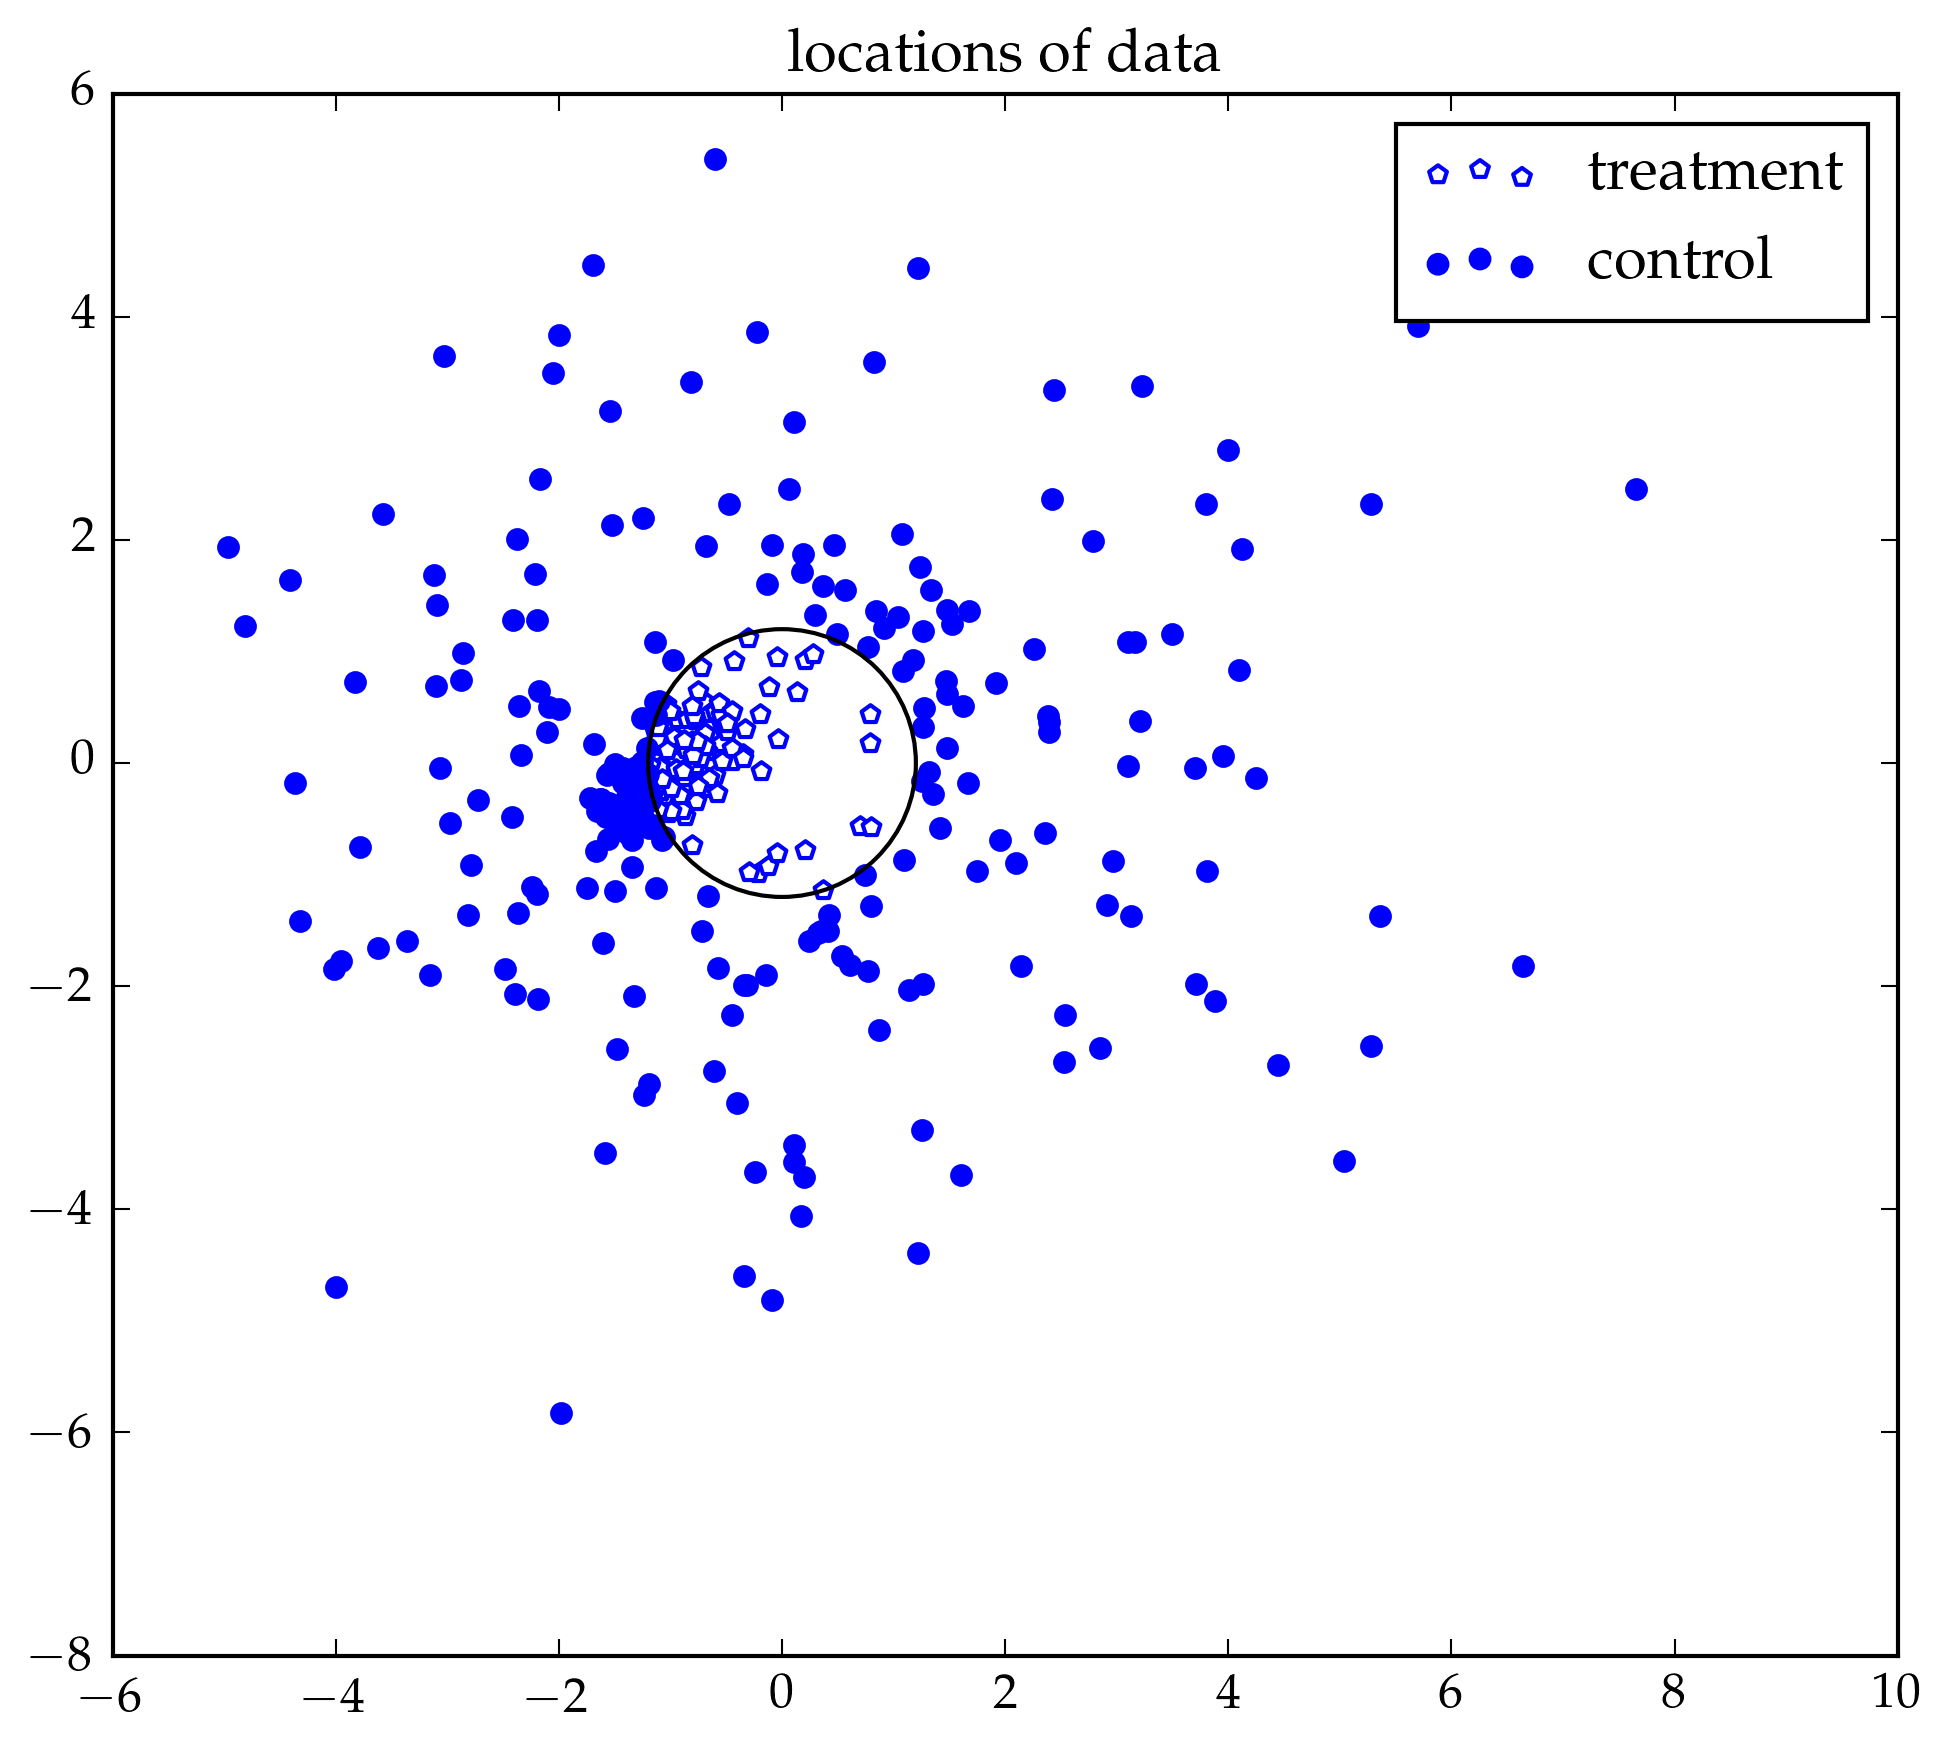

/Users/imolk/bin/venv_jupyter/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


In [2]:
city = MultivariateNormal([-1.0,0.0], [[0.1,0.05] [0.05, 0.1]])
village = MultivariateNormal([1.0,1.0], [[0.3,-0.1] [-0.1, 0.3]])
countryside = MultivariateNormal([0.0, 0.0], [[5.0,0.0] [0.0, 5.0]])
ncity = 180
nvillage = 10
ncountryside = 200
X=[rand(city, ncity) rand(village, nvillage) rand(countryside, ncountryside)]
_,n = size(X)
r◫ = 1.2
inside = vec((X[1,:].^2 .+ X[2,:].^2) .< r◫^2)
plt.scatter(X[1,inside],X[2,inside], color="white", edgecolor="blue", marker="p", label="treatment")
plt.scatter(X[1,!inside],X[2,!inside], color="blue", label="control")
circle=plt.plt[:Circle]((0,0),r◫,color="black", fill=false)
plt.gca()[:add_artist](circle)
plt.gca()[:set_aspect]("equal")
plt.title("locations of data")
plt.legend(loc="best")
;

# Simulate data from GP

In [3]:
Lstar=1.0
σf_star=2.0
σy2_star=0.5
τstar = 2.0 # strong treatment effect
kern = SE(log(Lstar), log(σf_star))

Type: GaussianProcesses.SEIso, Params: [0.0,0.6931471805599453]


In [4]:
Σprior=cov(kern, X)
μprior=zeros(n)
Σobs=copy(Σprior)
for i in 1:n
    Σobs[i,i] += σy2_star
end
prior=MultivariateNormal(μprior,Σobs)
Y=rand(prior)
Y[inside] .+= τstar # treatment effect applied inside circle
;

In [5]:
n◫ = 120
α◫ = linspace(0,2π,n◫)
x1◫ = cos(α◫)*r◫
x2◫ = sin(α◫)*r◫
X◫ = [x1◫ x2◫]'
size(X◫)

(2,120)

# 2GP Inference

Here's the plan:
1. Fit a GP on both sides of the treatment effect
2. Extrapolate both GP's to the boundary
3. Take the difference of the two predictions (good news: that's still a GP)
4. Make a pretty plot of the treatment effect band $\tau(x)$

In [6]:
gp_fit_inside = GP(X[:,inside], Y[inside], MeanZero(), kern, log(σy2_star))
gp_fit_outside = GP(X[:,!inside], Y[!inside], MeanZero(), kern, log(σy2_star))
;

In [7]:
pred_inside = predict(gp_fit_inside, X◫; full_cov=true)
pred_outside = predict(gp_fit_outside, X◫; full_cov=true)
;

In [8]:
μposterior = pred_inside[1].-pred_outside[1]
Σposterior = pred_inside[2]+pred_outside[2]
;

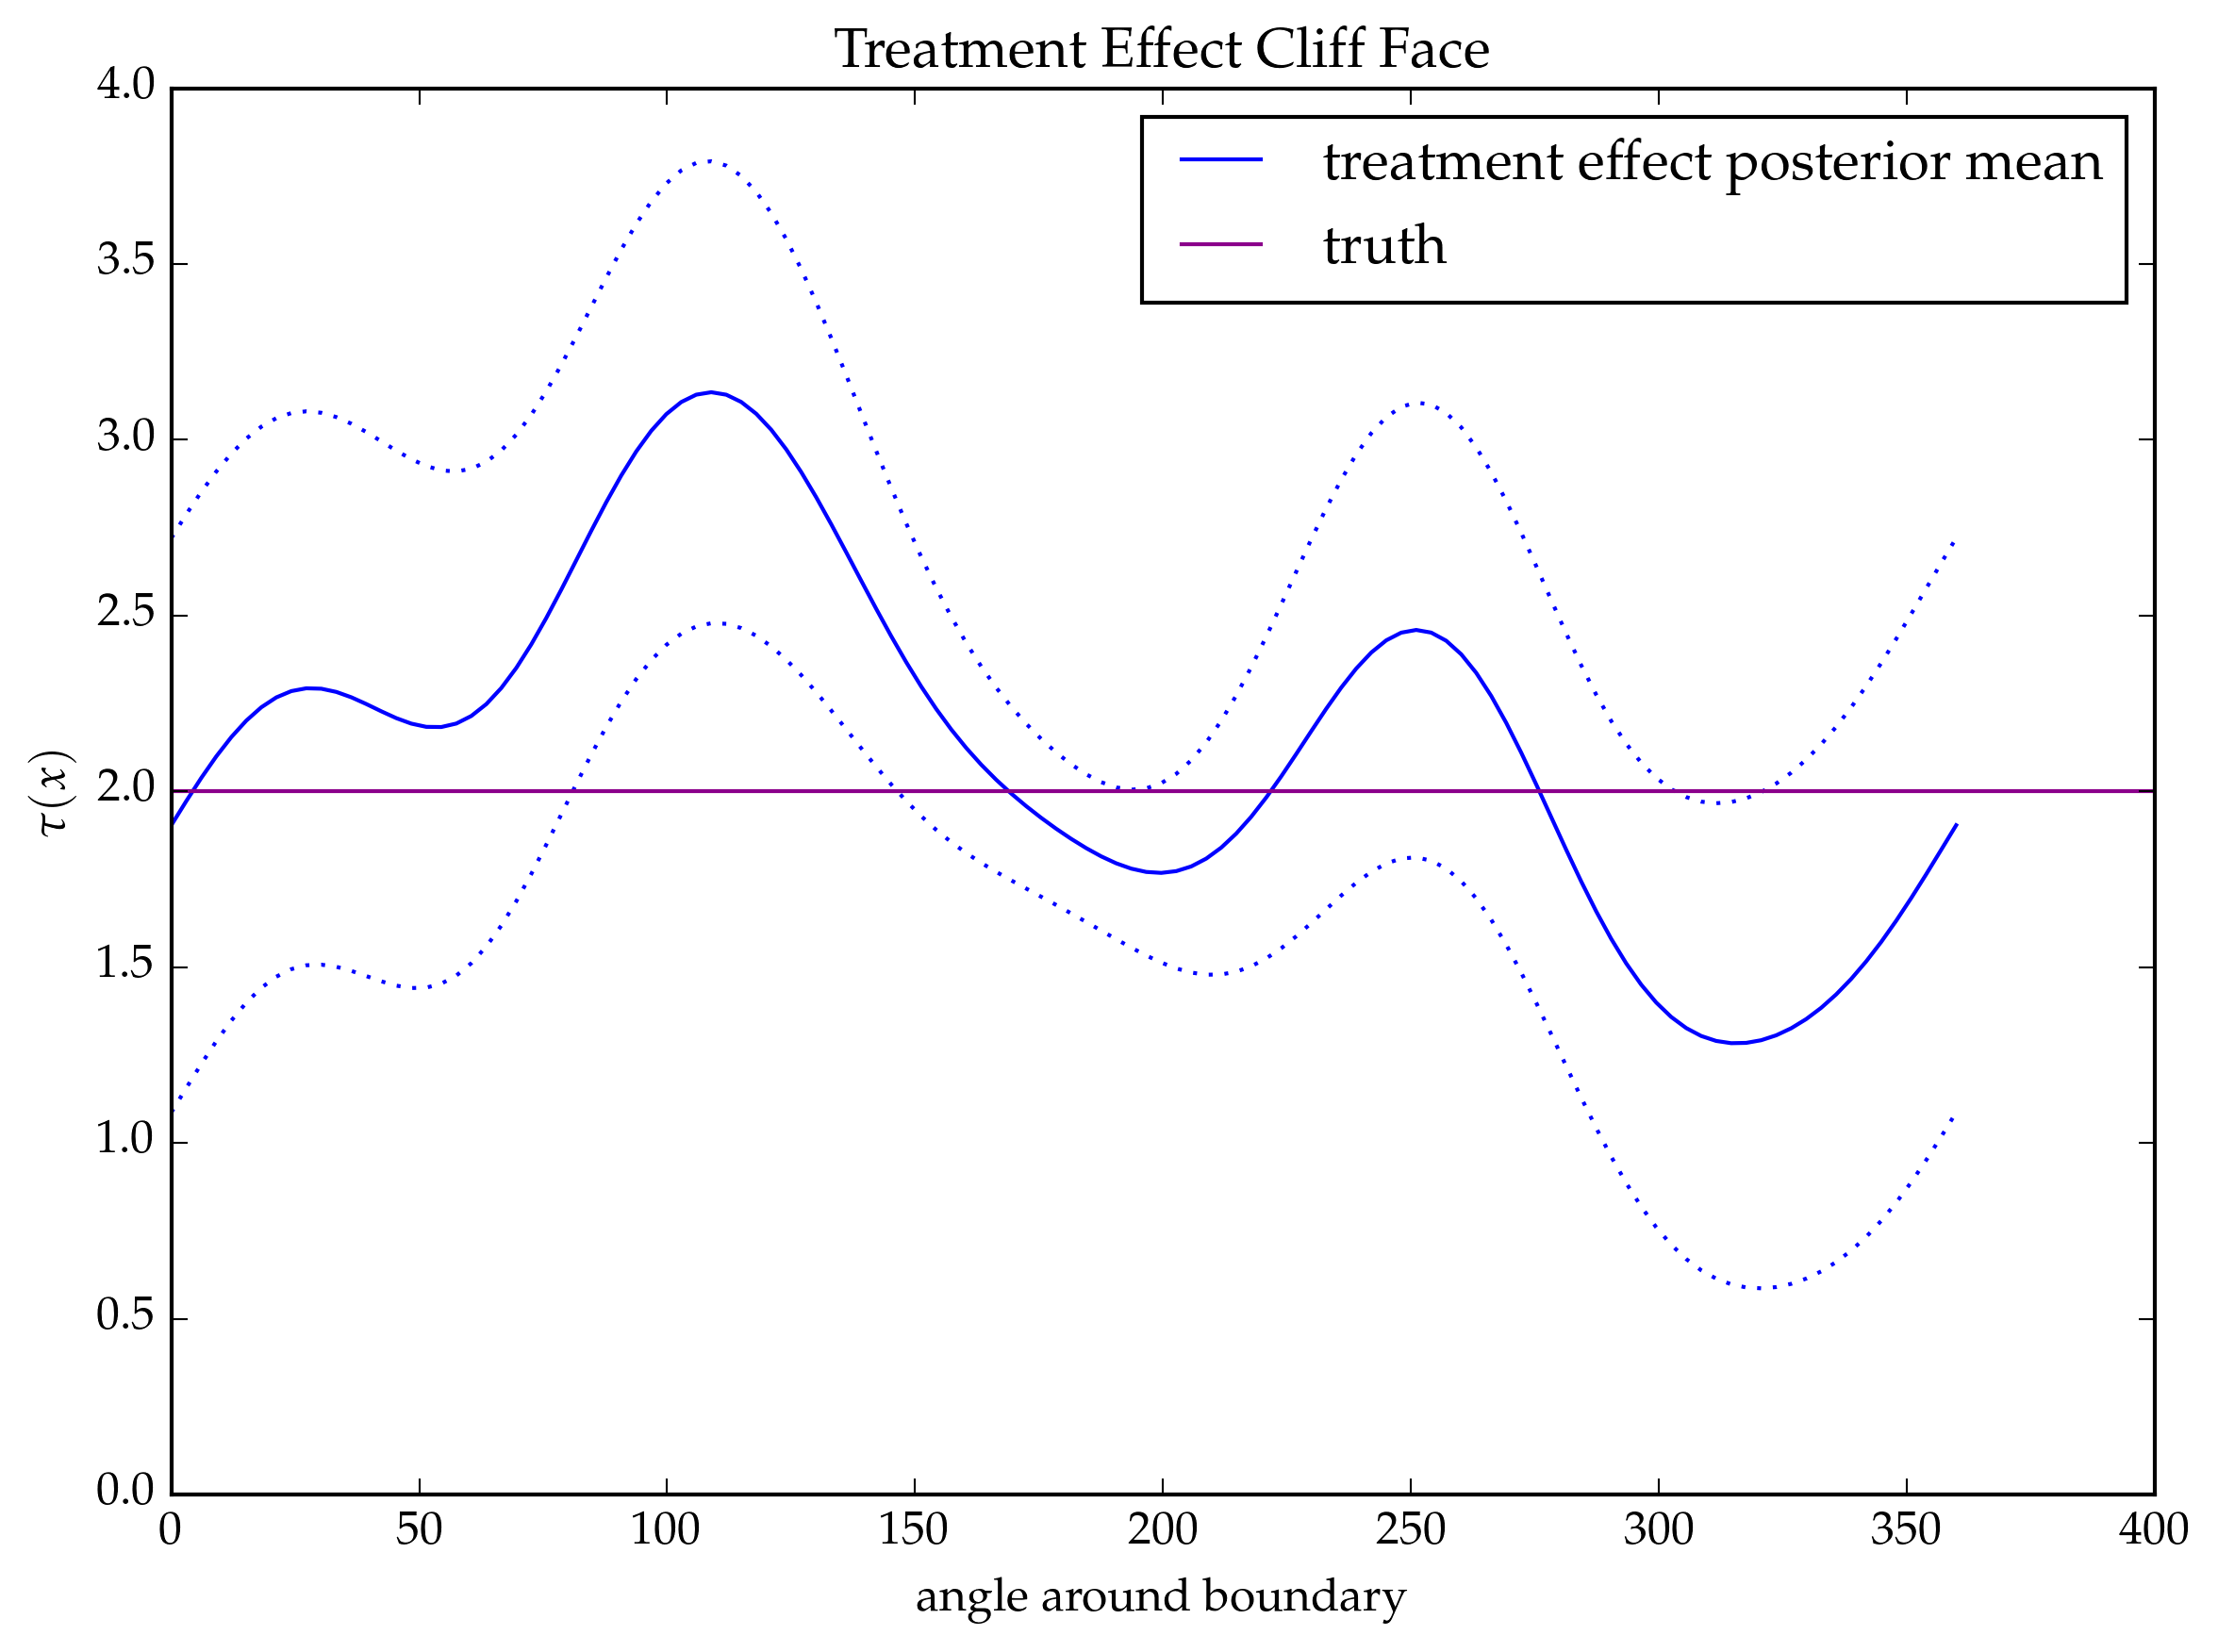

In [9]:
PyPlot.plt[:interactive](true)
plt.title("Treatment Effect Cliff Face")
PyPlot.plt[:interactive](false)
plt.plot(α◫*360/2π, μposterior, color="blue", label="treatment effect posterior mean")
plt.plot(α◫*360/2π, μposterior.+√diag(Σposterior), color="blue", linestyle=":")
plt.plot(α◫*360/2π, μposterior.-√diag(Σposterior), color="blue", linestyle=":")
plt.axhline(y=0, color="black")
plt.axhline(y=2, color="darkmagenta", label="truth")
plt.ylabel(L"\tau(x)")
plt.xlabel("angle around boundary")
plt.legend()
PyPlot.plt[:interactive](true)
;

# Estimate mean treatment effect

The output of the 2GP model is a posterior distribution of $\tau_\discont \mid Y,X$. Conveniently, because it is the difference of two GPs, the posterior of $\tau$ is itself a GP. Concretely, we evaluate it on a grid along the boundary, and so the posterior is normally distributed with mean $\mu^{post}$ and $\Sigma^{post}$. 

Let's think a little bit about estimands and estimators. We discussed this in our meeting on May 5th, and all seemed to have very different ideas about this. I'll try to summarize them below.

## Overview

I will start by misrepresenting everyone's view. Please tell me if this is an inaccurate misrepresentation of what you said, so I can 
* Maxime: Averaging the treatment effect along the boundary with inverse-variance weights makes the most sense to me
* Luke M: Think about the estimand first. To get a finite population estimate, we should impute potential outcomes of units, and average over those .
* Luke B: Explicitly model the treatment affect along the boundary. This is more compatible with the 1GP model, where the model has a treatment effect component.
* Zach: This is not our problem. We should let the practicioner decide how much weight to give to different places along the boundary.

## Maxime's original ideas
### Distance-averaged treatment effect
The first idea is to just average the posterior treatment effect along the boundary. 
\begin{align}
    \tau &= \frac{\oint_\discont \left. \tau(x) dx \right.}{\oint_\discont \left. dx \right.} \\
    \hat{\tau} &= \frac{\oint_\discont \left. \tau(x \mid Y,X) dx \right.}{\oint_\discont \left. dx \right.} \\
    \E\hat{\tau} &\approx \frac{\sum_{j=1}^n \left. \mu^{post}_j \right.}{n} \\
        &= \ones_n^\intercal \mu^{post} / n\\
    \V\hat{\tau} &\approx \frac{\sum_{i=1}^n \sum_{j=1}^n \Sigma^{post}_{ij}}{n^2} \\
        &= \ones_n^\intercal  \Sigma^{post} \ones_n / n^2
\end{align}
This assumes the chosen grid along the boundary is evenly sampled. Otherwise, we need to account for the space occupied by each point. We would encode this with $\delta$, a vector of the lengths of the boundary occupied by each point in $X_\discont$, and we would get
\begin{align}
    \E\hat{\tau} &\approx \frac{\delta^\intercal \mu^{post}}{\delta^\intercal \ones_n} \\
    \V\hat{\tau} &\approx \frac{\delta^\intercal \Sigma^{post} \delta}{\delta^\intercal \delta}
\end{align}

In [10]:
τhat_unweighted = sum(μposterior)/n◫
Vτhat_unweighted = sum(Σposterior.mat)/n◫^2
Normal(τhat_unweighted, √Vτhat_unweighted)

Distributions.Normal(μ=2.135267063415776, σ=0.2767669519376675)

The problem with this is that the estimated variance $\V\hat{\tau}$ will blow up if there are sparsely populated segments of the boundary. It's the correct estimator for this estimand, but inference is essentially impossible if there are parts of the boundary where nobody lives (let's say the boundary goes through a big lake for example).

### Inverse-variance weighted treatment effect

This leads to the idea of downweighting the local treatment effects by their posterior variance. We are upweighting segments with high certainty, and downweighting high-variance segments of the boundary. My intuition is that instead of giving the same weight to each boundary length, we give the same length to each datapoint along the boundary (downweighted for units further away from the boundary). If we have twice as many people living in one area, the variance will be halved, and hence the weight doubled.

\begin{align}
    \E\hat{\tau} &= \frac{\ones_n^T \Sigma^{-1} \mu^{post}}{\ones_n^T \Sigma^{-1} \ones_n} \\
    \V\hat{\tau} &= \frac{\ones_n^T \Sigma^{-1} \ones_n}{\del{\ones_n^T \Sigma^{-1} \ones_n}^2} \\
    &= 1 \big/ \del{\ones_n^T \Sigma^{-1} \ones_n}
\end{align}

In [11]:
denom_weighted = dot(ones(n◫),(Σposterior \ ones(n◫)))
τhat_weighted = sum(Σposterior\μposterior) / denom_weighted
Vτhat_weighted = 1/denom_weighted
Normal(τhat_weighted, √Vτhat_weighted)

Distributions.Normal(μ=1.9415920333895638, σ=0.1696417503369096)

This estimator is closer to the true $\tau=2.0$ and has a lower posterior variance.

### Simulate under the null

Let's see how the two estimators behave under the null hypothesis of $\tau(x)=0$. To save ourselves some trouble, we'll keep the positions of the data fixed, so we can just simulate a new $Y$, thus leaving the covariance matrix unchanged. We then apply the two estimators, and then look at the distribution of the effect size $\E\del{\hat\tau \mid Y,X} / \sqrt{\V\del{\hat\tau \mid Y,X}}$. We want it to be close to zero.

In [12]:
function update_alpha!(gp::GP)
    m = GaussianProcesses.mean(gp.m,gp.x)
    gp.alpha = gp.cK \ (gp.y - m)
end
type SimOutput
    τhat::Float64
    Vτhat::Float64
end
effsize(so::SimOutput) = so.τhat/√(so.Vτhat)

function sim_null()
    Ystar = rand(prior)
    gp_fit_inside.y = Ystar[inside]
    gp_fit_outside.y = Ystar[!inside]
    update_alpha!(gp_fit_inside)
    update_alpha!(gp_fit_outside)
    extrap◫_inside = predict(gp_fit_inside, X◫; full_cov=true)
    extrap◫_outside = predict(gp_fit_outside, X◫; full_cov=true)
    μpost = extrap◫_inside[1].-extrap◫_outside[1]
    Σpost = extrap◫_inside[2]+extrap◫_outside[2]
    
    # simple average, unweighted
    τhat = sum(μpost)/n◫
    Vτhat = sum(Σpost.mat)/n◫^2
    unweighted = SimOutput(τhat, Vτhat)
    
    # inverse variance weighted
    denom = dot(ones(n◫),(Σpost \ ones(n◫)))
    τhat = sum(Σpost\μpost) / denom
    Vτhat = 1/denom
    invvariance = SimOutput(τhat, Vτhat)
    
    return unweighted, invvariance
end

eff_null = [sim_null() for _ in 1:10000];

It is a [mathematical fact](https://en.wikipedia.org/wiki/Inverse-variance_weighting) that the inverse-variance weighted average has the lowest possible variance of all weighted averages of a vector. Let's check this is true in all our simulations:

In [13]:
all(Bool[sim[1].Vτhat >= sim[2].Vτhat for sim in eff_null])

true

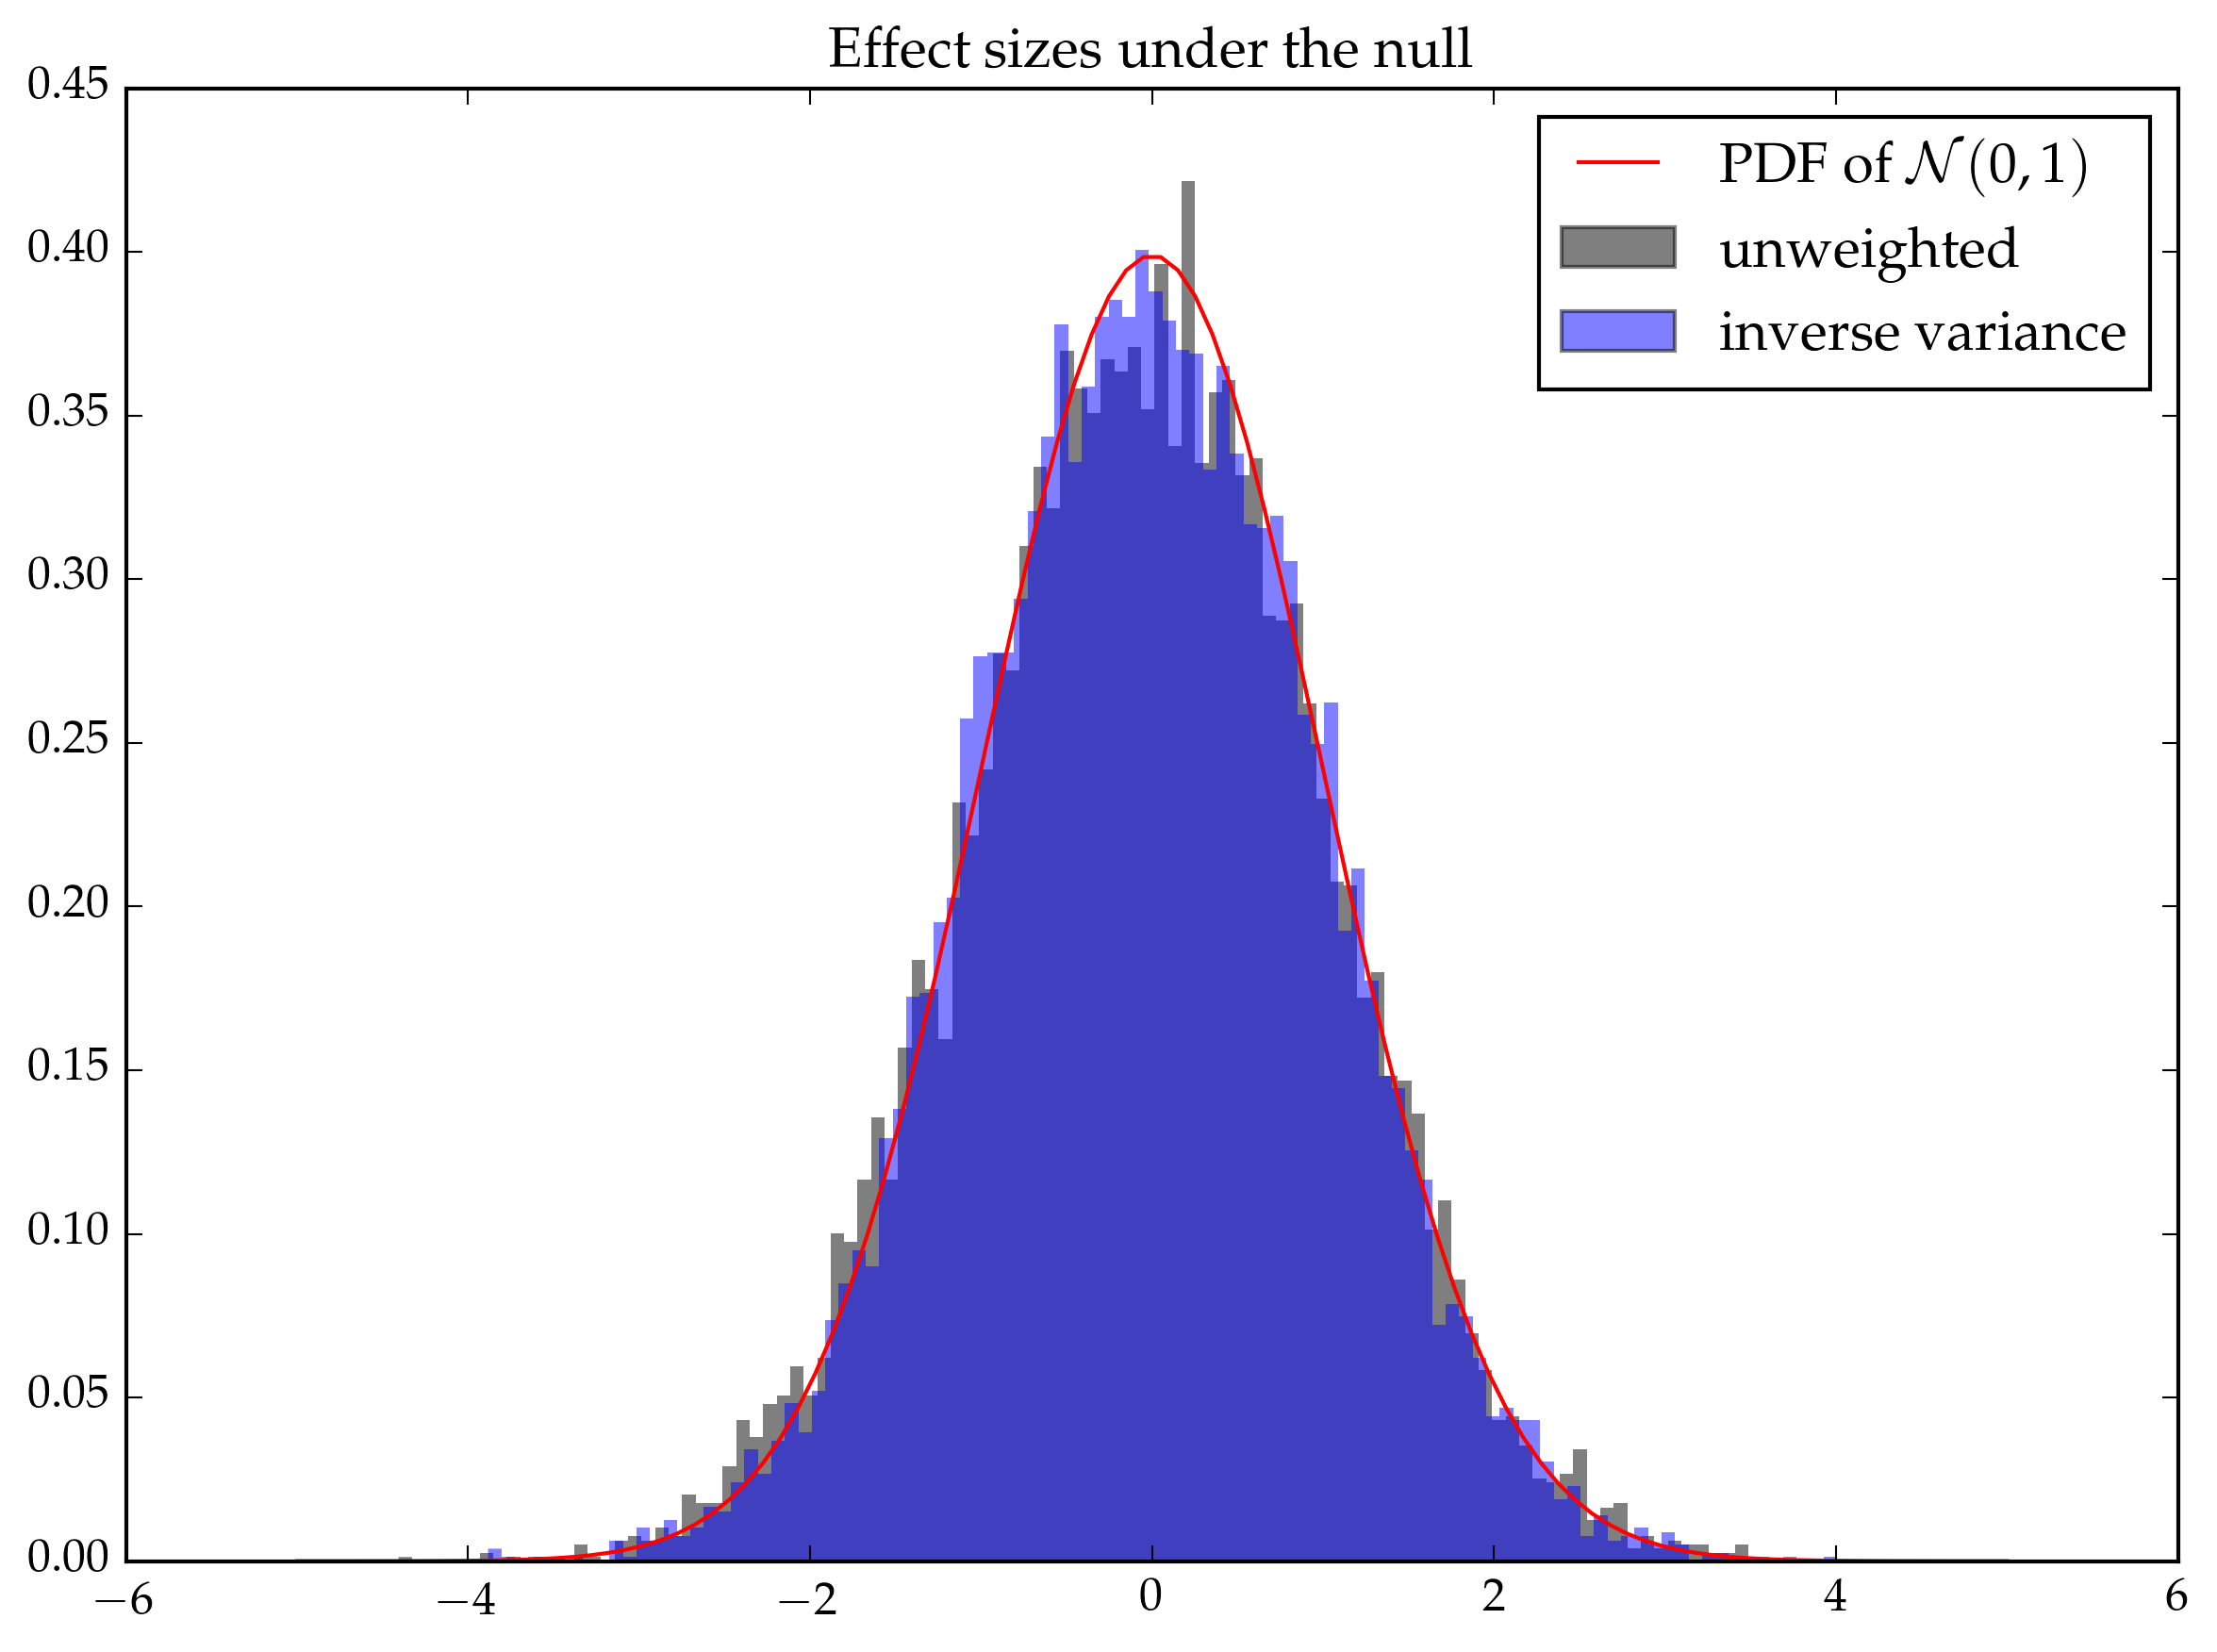

In [14]:
PyPlot.plt[:interactive](true)
plt.title("Effect sizes under the null")
PyPlot.plt[:interactive](false)
plt.plt[:hist](Float64[effsize(sim[1]) for sim in eff_null], 
        bins=100, color="black", alpha=0.5, edgecolor="none", normed=true, label="unweighted")
plt.plt[:hist](Float64[effsize(sim[2]) for sim in eff_null], 
        bins=100, color="blue", alpha=0.5, edgecolor="none", normed=true, label="inverse variance")
xx=linspace(-5.0,5.0,100)
plt.plot(xx, pdf(Normal(), xx), color="red", label=L"PDF of $\mathcal{N}(0,1)$")
plt.title("Effect sizes under the null")
plt.legend()
PyPlot.plt[:interactive](true)
;

Interesting! The standardized effect $\E\hat{\tau} \big/ \sqrt{\V\hat{\tau}}$ is roughly a standard normal for both estimators. Encouraging...

### Simulate under alternative

Now let's see what happens when $\tau(x)=0.5$ is fixed and constant. Again, we keep the positions fixed and simulate new outcomes, then apply the two estimators.

In [16]:
function sim_alt(τ::Float64)
    Ystar = rand(prior)
    Ystar[inside] .+= τ
    gp_fit_inside.y = Ystar[inside]
    gp_fit_outside.y = Ystar[!inside]
    update_alpha!(gp_fit_inside)
    update_alpha!(gp_fit_outside)
    extrap◫_inside = predict(gp_fit_inside, X◫; full_cov=true)
    extrap◫_outside = predict(gp_fit_outside, X◫; full_cov=true)
    μpost = extrap◫_inside[1].-extrap◫_outside[1]
    Σpost = extrap◫_inside[2]+extrap◫_outside[2]
    
    # simple average, unweighted
    τhat = sum(μpost)/n◫
    Vτhat = sum(Σpost.mat)/n◫^2
    unweighted = SimOutput(τhat, Vτhat)
    
    # inverse variance weighted
    denom = dot(ones(n◫),(Σpost \ ones(n◫)))
    τhat = sum(Σpost\μpost) / denom
    Vτhat = 1/denom
    invvariance = SimOutput(τhat, Vτhat)
    
    return unweighted, invvariance
end
eff_alt = [sim_alt(0.5) for _ in 1:10000];

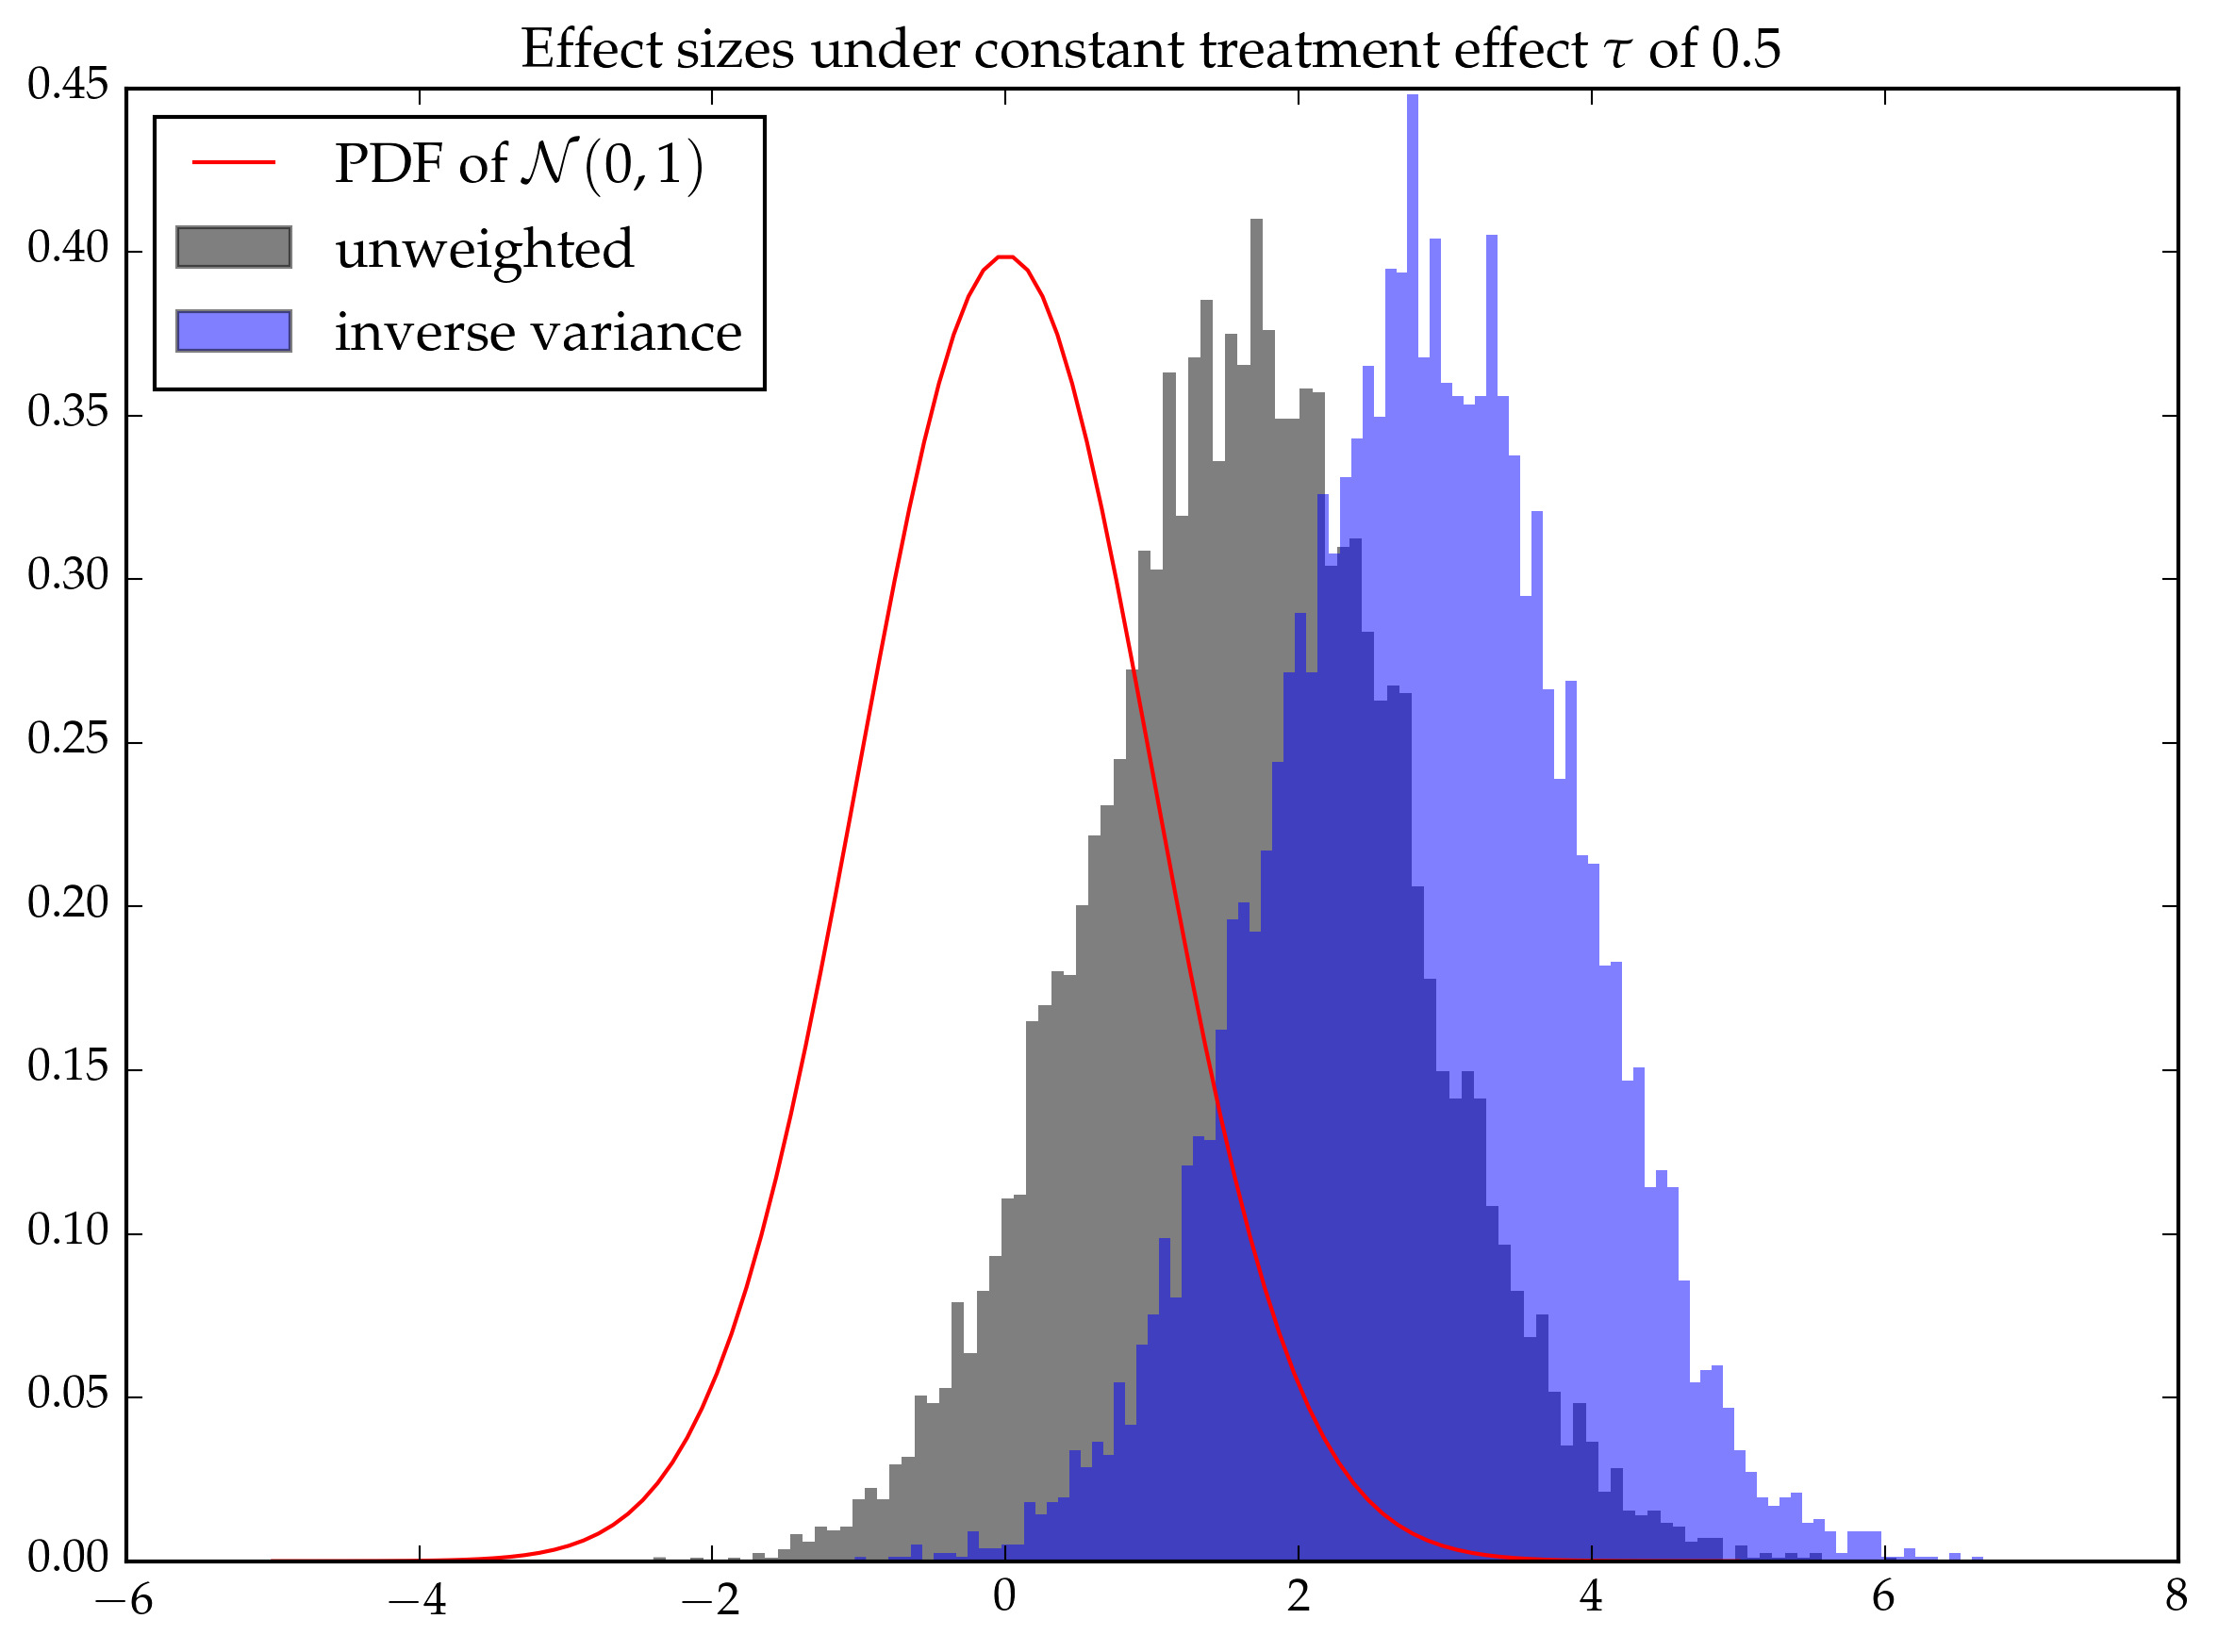

In [17]:
PyPlot.plt[:interactive](true)
plt.title(L"Effect sizes under constant treatment effect $\tau$ of 0.5")
PyPlot.plt[:interactive](false)
plt.plt[:hist](Float64[effsize(sim[1]) for sim in eff_alt], 
        bins=100, color="black", alpha=0.5, edgecolor="none", normed=true, label="unweighted")
plt.plt[:hist](Float64[effsize(sim[2]) for sim in eff_alt], 
        bins=100, color="blue", alpha=0.5, edgecolor="none", normed=true, label="inverse variance")
xx=linspace(-5.0,5.0,100)
plt.plot(xx, pdf(Normal(), xx), color="red", label=L"PDF of $\mathcal{N}(0,1)$")
plt.legend(loc="upper left")
PyPlot.plt[:interactive](true)
;

Not too bad! This seems to be doing something sensible. It seems pretty clear that the inverse-variance estimator will have higher power to detect a constant effect like this.

## Estimand-first approach: finite population average

In Luke's view, we will gain more insight by focusing on the estimand rather than the estimator. His first intuition was that we should be imputing potential outcomes under the alternative treatment for all units, and then take an average, to get a finite population average. Computationally, this isn't too hard: we use each GP to generate predictions for all units, then take the difference, which will still be multi-variate normal, so the average of those will be nicely normal.

In [19]:
pred_treatment = predict(gp_fit_inside, X; full_cov=true)
pred_control = predict(gp_fit_outside, X; full_cov=true)
pred_effect_μ = pred_treatment[1].-pred_control[1]
pred_effect_Σ = pred_treatment[2].mat .+ pred_control[2].mat
τhat_LukeM = mean(pred_effect_μ)
Vτhat_LukeM = sum(pred_effect_Σ) / n^2
Normal(τhat_LukeM, √Vτhat_LukeM)

Distributions.Normal(μ=0.3619466471388757, σ=0.2611198265021462)

In my view, the flaw of this approach is that it gives equal weight to people near the boundary and people away from the boundary, in contradiction of RDD principles. Away from the boundary, the treatment effect will be dominated by the prior, and so asymptotically (as we get more and more data away from the boundary), the posterior treatment effect will go to zero (in this case, since there's no mean term in the model, otherwise something like the difference in empirical means), with variance also zero. Here, we see that $\E\tau$ is much lower than the true $\tau=2.0$, despite the low posterior variance.

## Luke M's density-weighted approach

In our following meeting, LukeM proposed a different estimand: the treatment effect averaged over the boundary, and weighted by a local population density estimate. This is nice because it is readily interpretable by practicioners: we are giving more weight to dense areas, and zero weight to empty areas.

Let $\hat{\rho}(x)$ be the local population density estimate, estimated on a grid along the boundary, and normalized so $\sum \hat{\rho}(x_i)=1$. Then the estimate is given by
\begin{align}
    \E\hat{\tau} = \hat{\rho}^\intercal \mu^{post} \\
    \V\hat{\tau} = \hat{\rho}^\intercal \Sigma^{post} \hat{\rho}\  \\
\end{align}

This leaves the question of how to estimate the local density. We'll start with a quick and dirty kernel density estimate, with an arbitrarily chosen bandwidth.

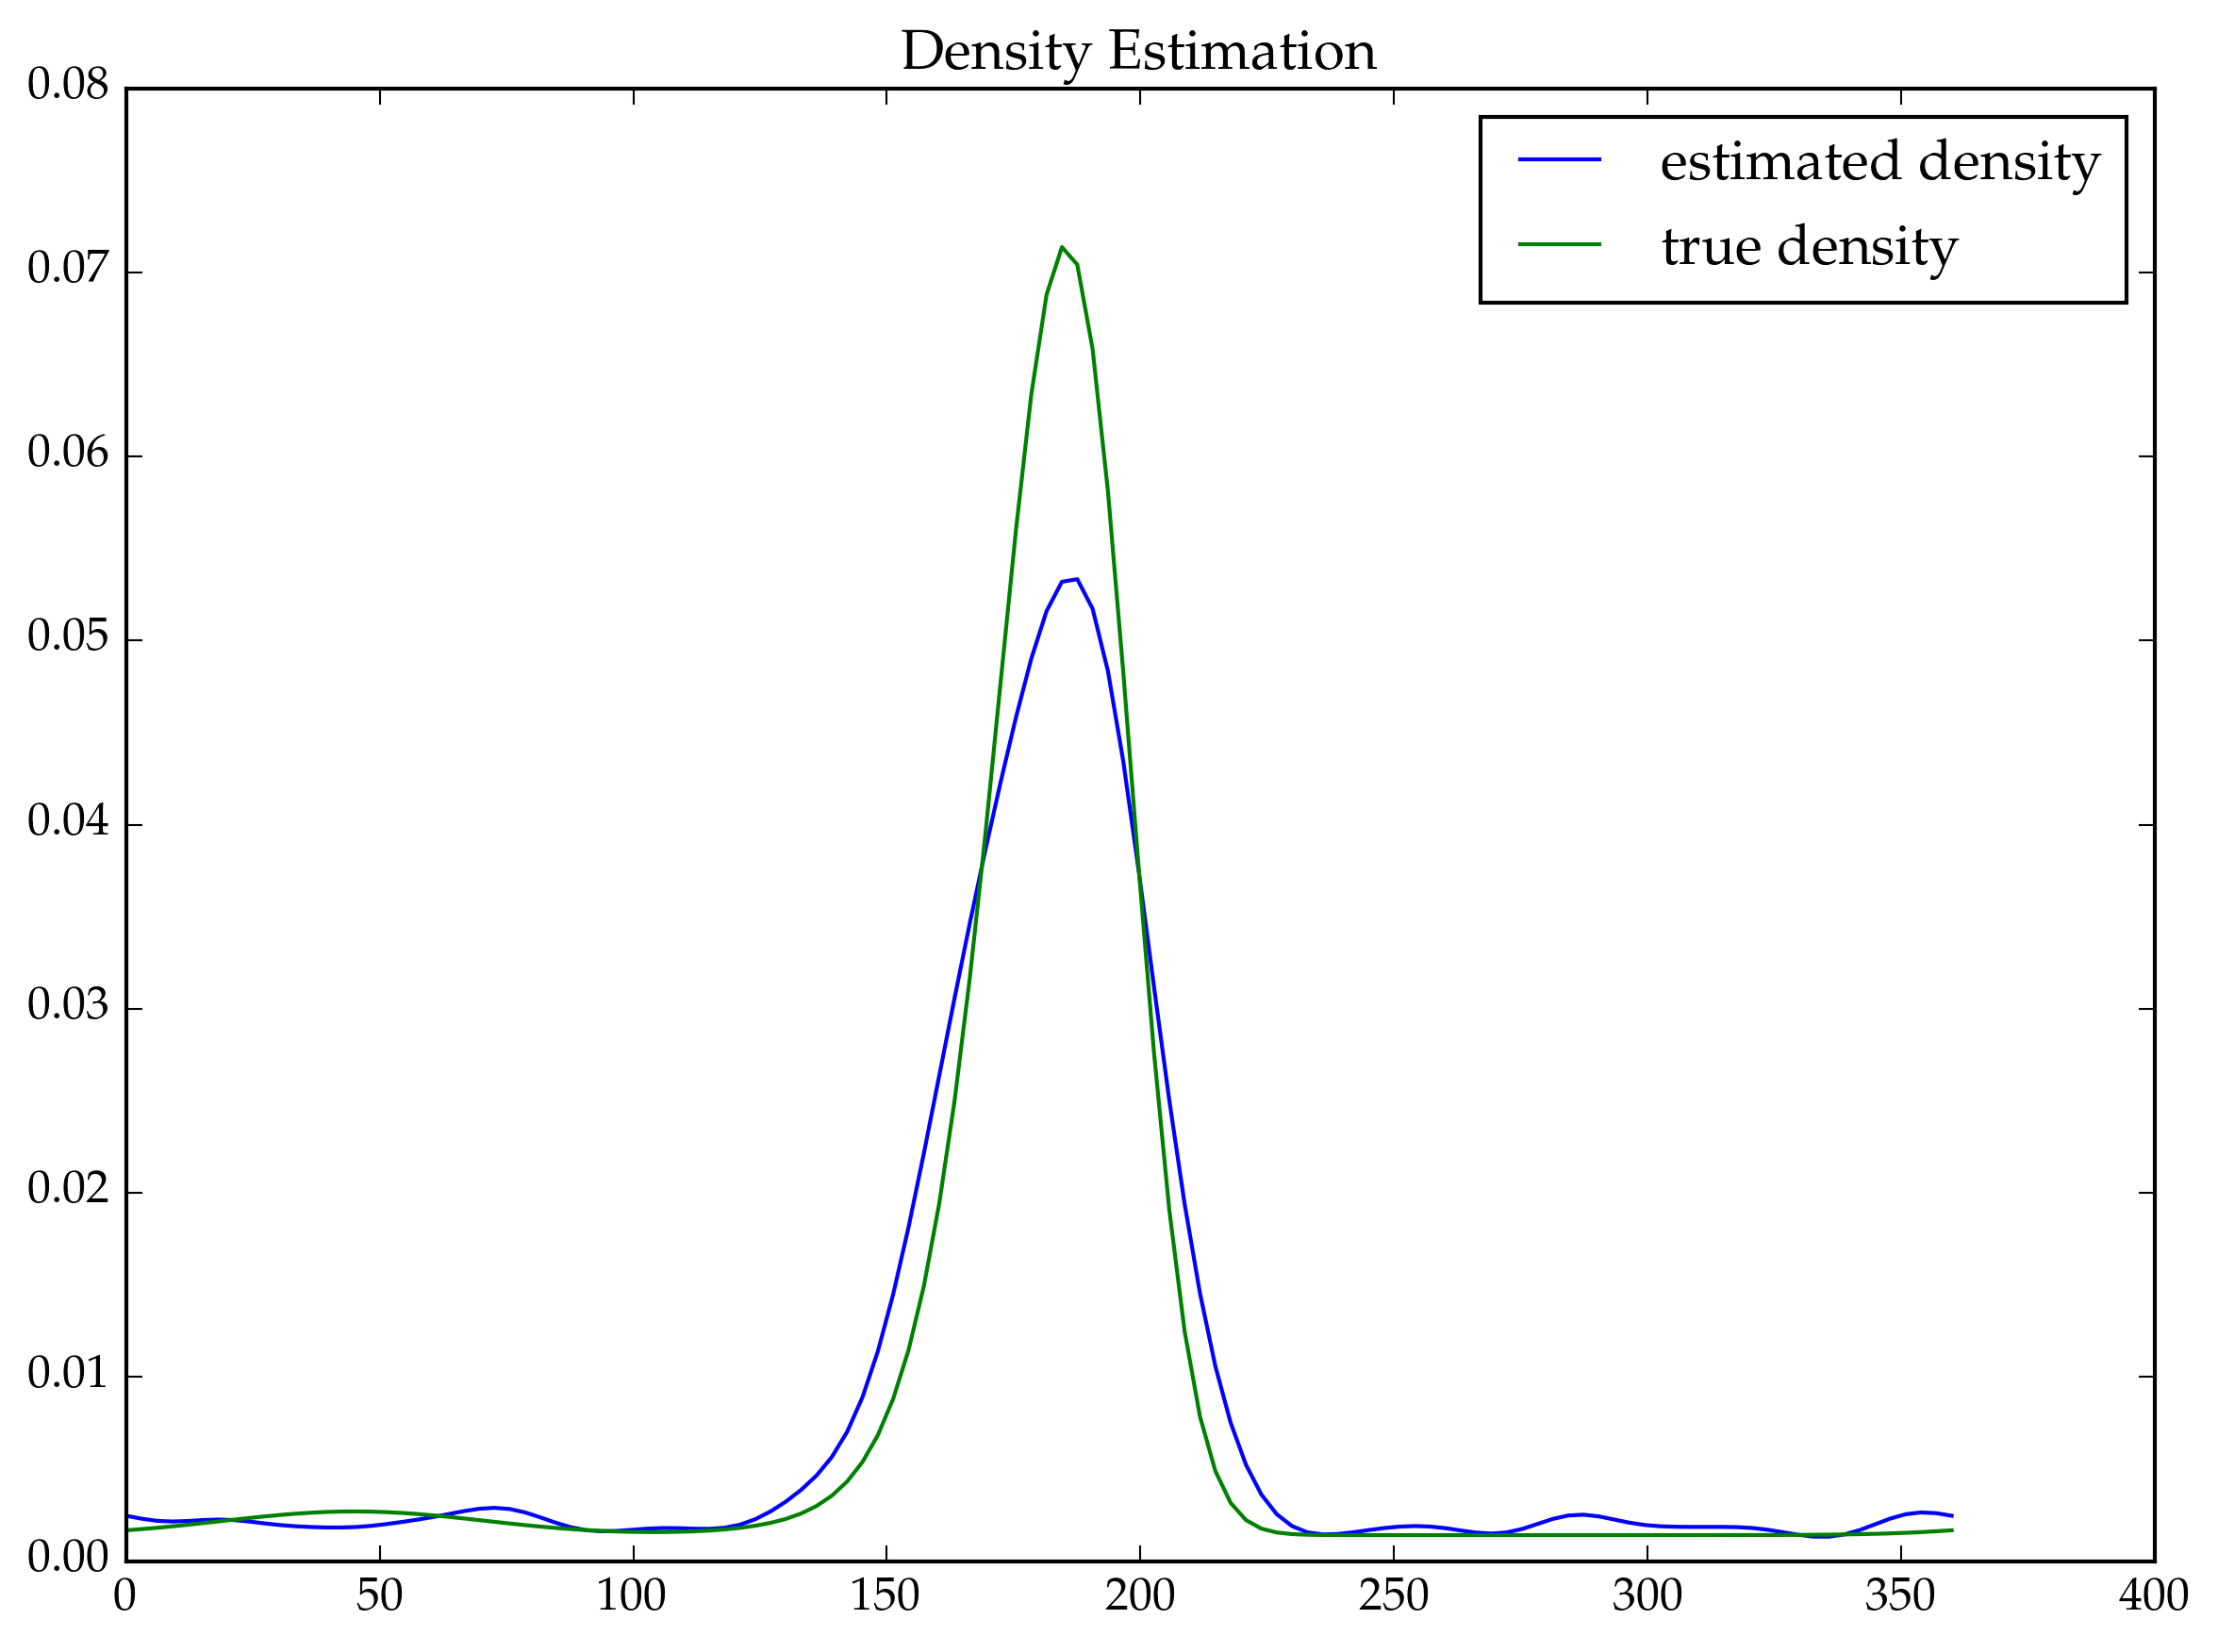

In [20]:
density_estimate = vec(sum(pdf(Normal(0.0, 0.2), pairwise(Euclidean(), X, X◫)), 1))
density_truth = [(ncity*pdf(city, X◫[:,i])
                +nvillage*pdf(village, X◫[:,i])
                +ncountryside*pdf(countryside, X◫[:,i]))
                for i in 1:n◫
                ]
density_estimate ./= sum(density_estimate)
density_truth ./= sum(density_truth)
plt.plt[:interactive](true)
plt.title("Density Estimation")
plt.plt[:interactive](false)
plt.plot(α◫*360/2π, density_estimate, label="estimated density")
plt.plot(α◫*360/2π, density_truth, label="true density")
plt.legend(loc="best")
plt.plt[:interactive](true)
;

In [21]:
density_weights = StatsBase.WeightVec(density_estimate)
τhat_density = mean(μposterior, density_weights)
Vτhat_density = dot(density_estimate, Σposterior*density_estimate) / sum(density_estimate)^2
Normal(τhat_density, √Vτhat_density)

Distributions.Normal(μ=1.974795755723017, σ=0.17157718453126053)

As expected, this gives a very similar answer to the inverse-variance weighted estimator (above), but with a slightly higher variance (the inverse-variance weighted mean is guaranteed to have the lowest variance). This is appealing, as it combines the nice mathematical properties of that estimator, with the interpretability of the density-weighted estimand.

However, I can foresee one problem with this scheme. The estimator doesn't incorporate the correlation structure of the posterior process $\tau(x)$. This means that if we have anything other than a regularly sampled grid, weird things could happen. I'm thinking of the scenario that LukeB conjured up, where a part of the boundary is fairly wiggly. That part of the boundary will then be given undeservedly *higher* weight, simply because it is longer, and will therefore contain more samples. In the extreme case of a fractal boundary, the result could be nonsensical.

The other negative point is that this requires an additional spatial model of the population density, solely for the purpose of deriving weights in our estimand. The kernel density approach requires tuning of the bandwidth. This extra step adds complexity and variance to the algorithm.

### Problematic wiggly boundaries

In this section, I want to do a quick simulation that shows the problem with the density-weighted estimator. Because the estimate ignores the covariance structure, it will give more weight to points along the boundary that are in wiggly sections, assuming all points are made equidistant.

To show this, I will create a boundary that is a triangular wave (zig-zag) between $x=0$ and $x=0.5$, and then just a straight line. The treatment effect isn't constant: it increases linearly from 0 at $x=0$ to 2 at $x=1$. That way, we will see that when the wiggly segment gains more influence, the estimate decreases. To distinguish the unweighted estimator from the density-weighted estimator, I also increase the density linearly with $x$. To avoid any confusion, I use the *true* density rather than an estimated density for the density-weighted estimator: the effect of the density estimation is irrelevant to the effect I wish to demonstrate.

In [22]:
# define boundary:
# below 0.5: triangular wave
# above 0.5: straight line
wb_l = 0.5/5
wb_A = 0.1
function boundary(x, l, A)
    if x < 0.5
        return abs(((x+l/4)*2*A/l) % 2A - A) - (A/2) 
    else
        return 0.0
    end
end
function wb_density(x)
    return 1+x
end

# define treatment effect 
function wb_τx(x)
    2*x
end

wb_τx (generic function with 1 method)

In this simulation setting, we can know the true value of the estimand. We will define the estimand as the density-weighted treatment effect when there are no wiggles. That way the grid of points along the boundary is evenly spaced, and the estimand is easily interpretable. We use $\rho(x)$ for the true population density at $x$.

$$ \tau = \frac{\int_0^1 \left. \tau(x) \rho(x) dx \right.}{\int_0^1 \left. \rho(x) dx \right.}$$

In [23]:
wb_xx = linspace(0.0,1.0,1000)
wb_τtrue = sum([wb_τx(x)*wb_density(x) for x in wb_xx])/sum([wb_density(x) for x in wb_xx])

1.1113335557779995

Now we simulate the data. First the locations, then the outcomes.

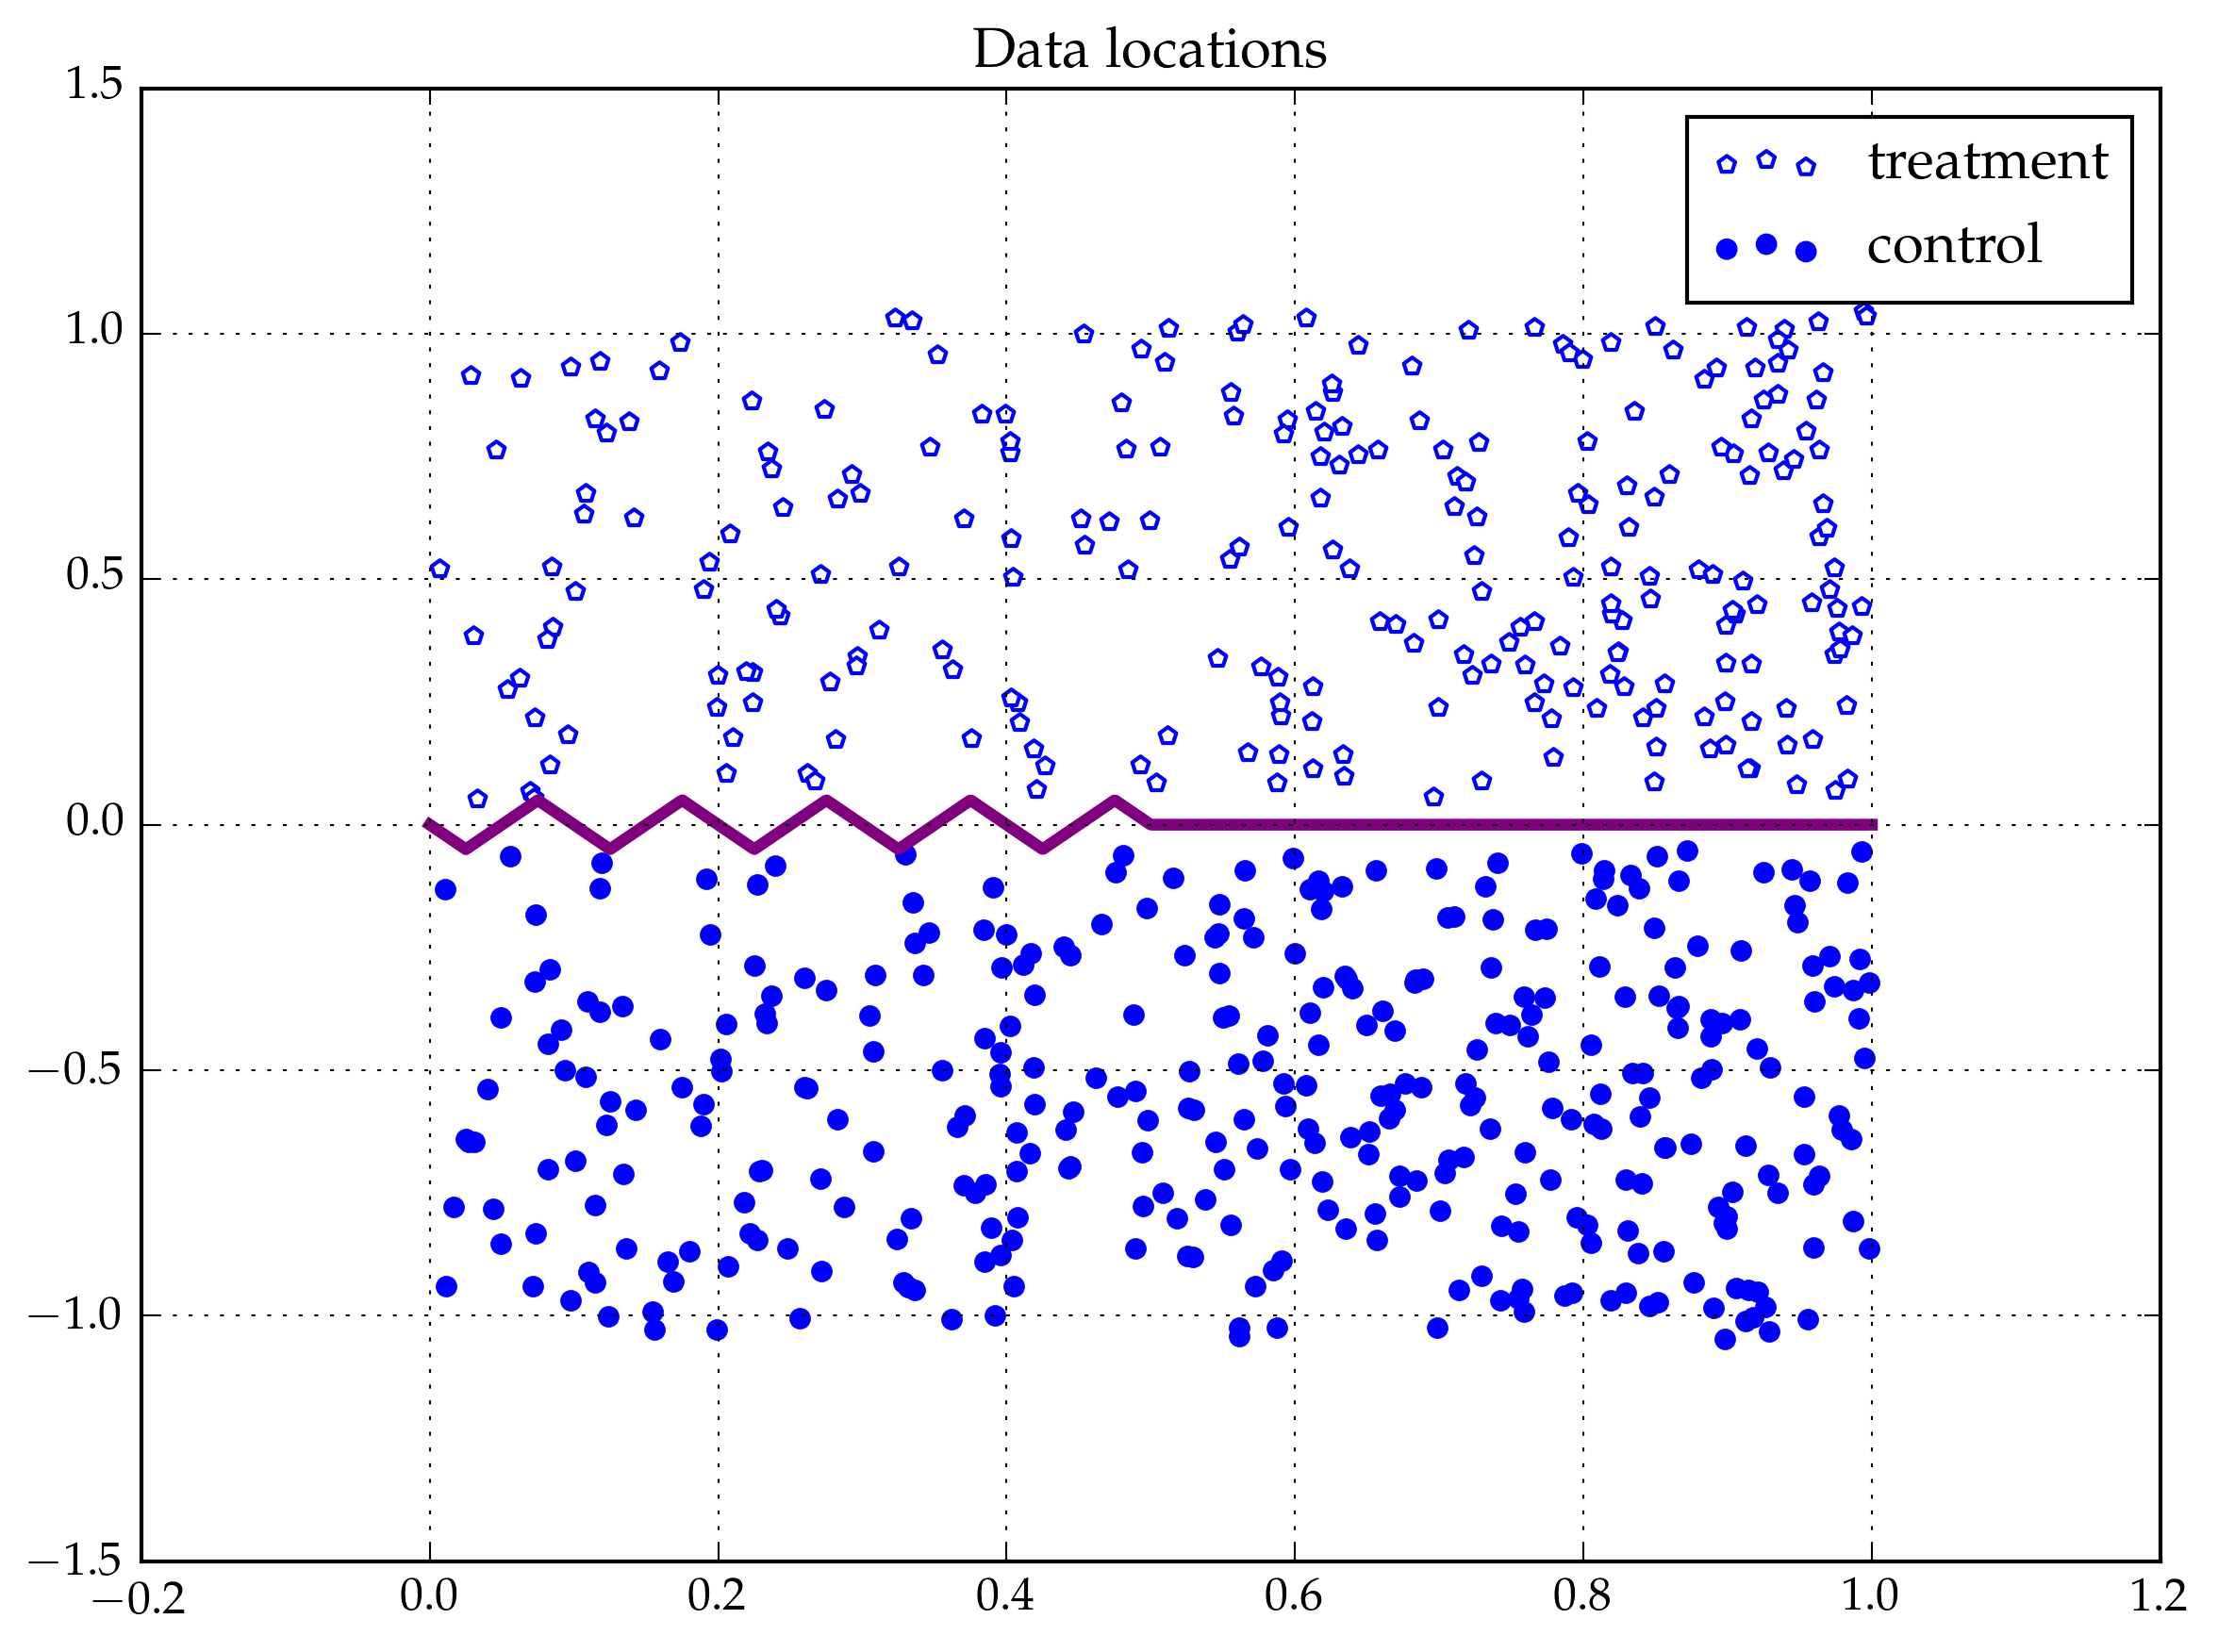

In [24]:
wb_n = 600
wb_ntreat = 250
wb_nctrol = wb_n-wb_ntreat
wbX_treat = rand(2,wb_ntreat)
wbX_treat[2,:] += 0.05
wbX_treat[1,:] = log(1+(exp(1)-1)*wbX_treat[1,:])
wbX_ctrol = rand(2,wb_nctrol)
wbX_ctrol[2,:] -= 1.05
wbX_ctrol[1,:] = log(1+(exp(1)-1)*wbX_ctrol[1,:])
plt.scatter(wbX_treat[1,:],wbX_treat[2,:], color="white", edgecolor="blue", marker="p", label="treatment")
plt.scatter(wbX_ctrol[1,:],wbX_ctrol[2,:], color="blue", label="control")
plt.plot(wb_xx, [boundary(x,wb_l,wb_A) for x in wb_xx], linewidth=3, color="purple")
plt.grid(true)
plt.title("Data locations")
plt.legend(loc="best")
;

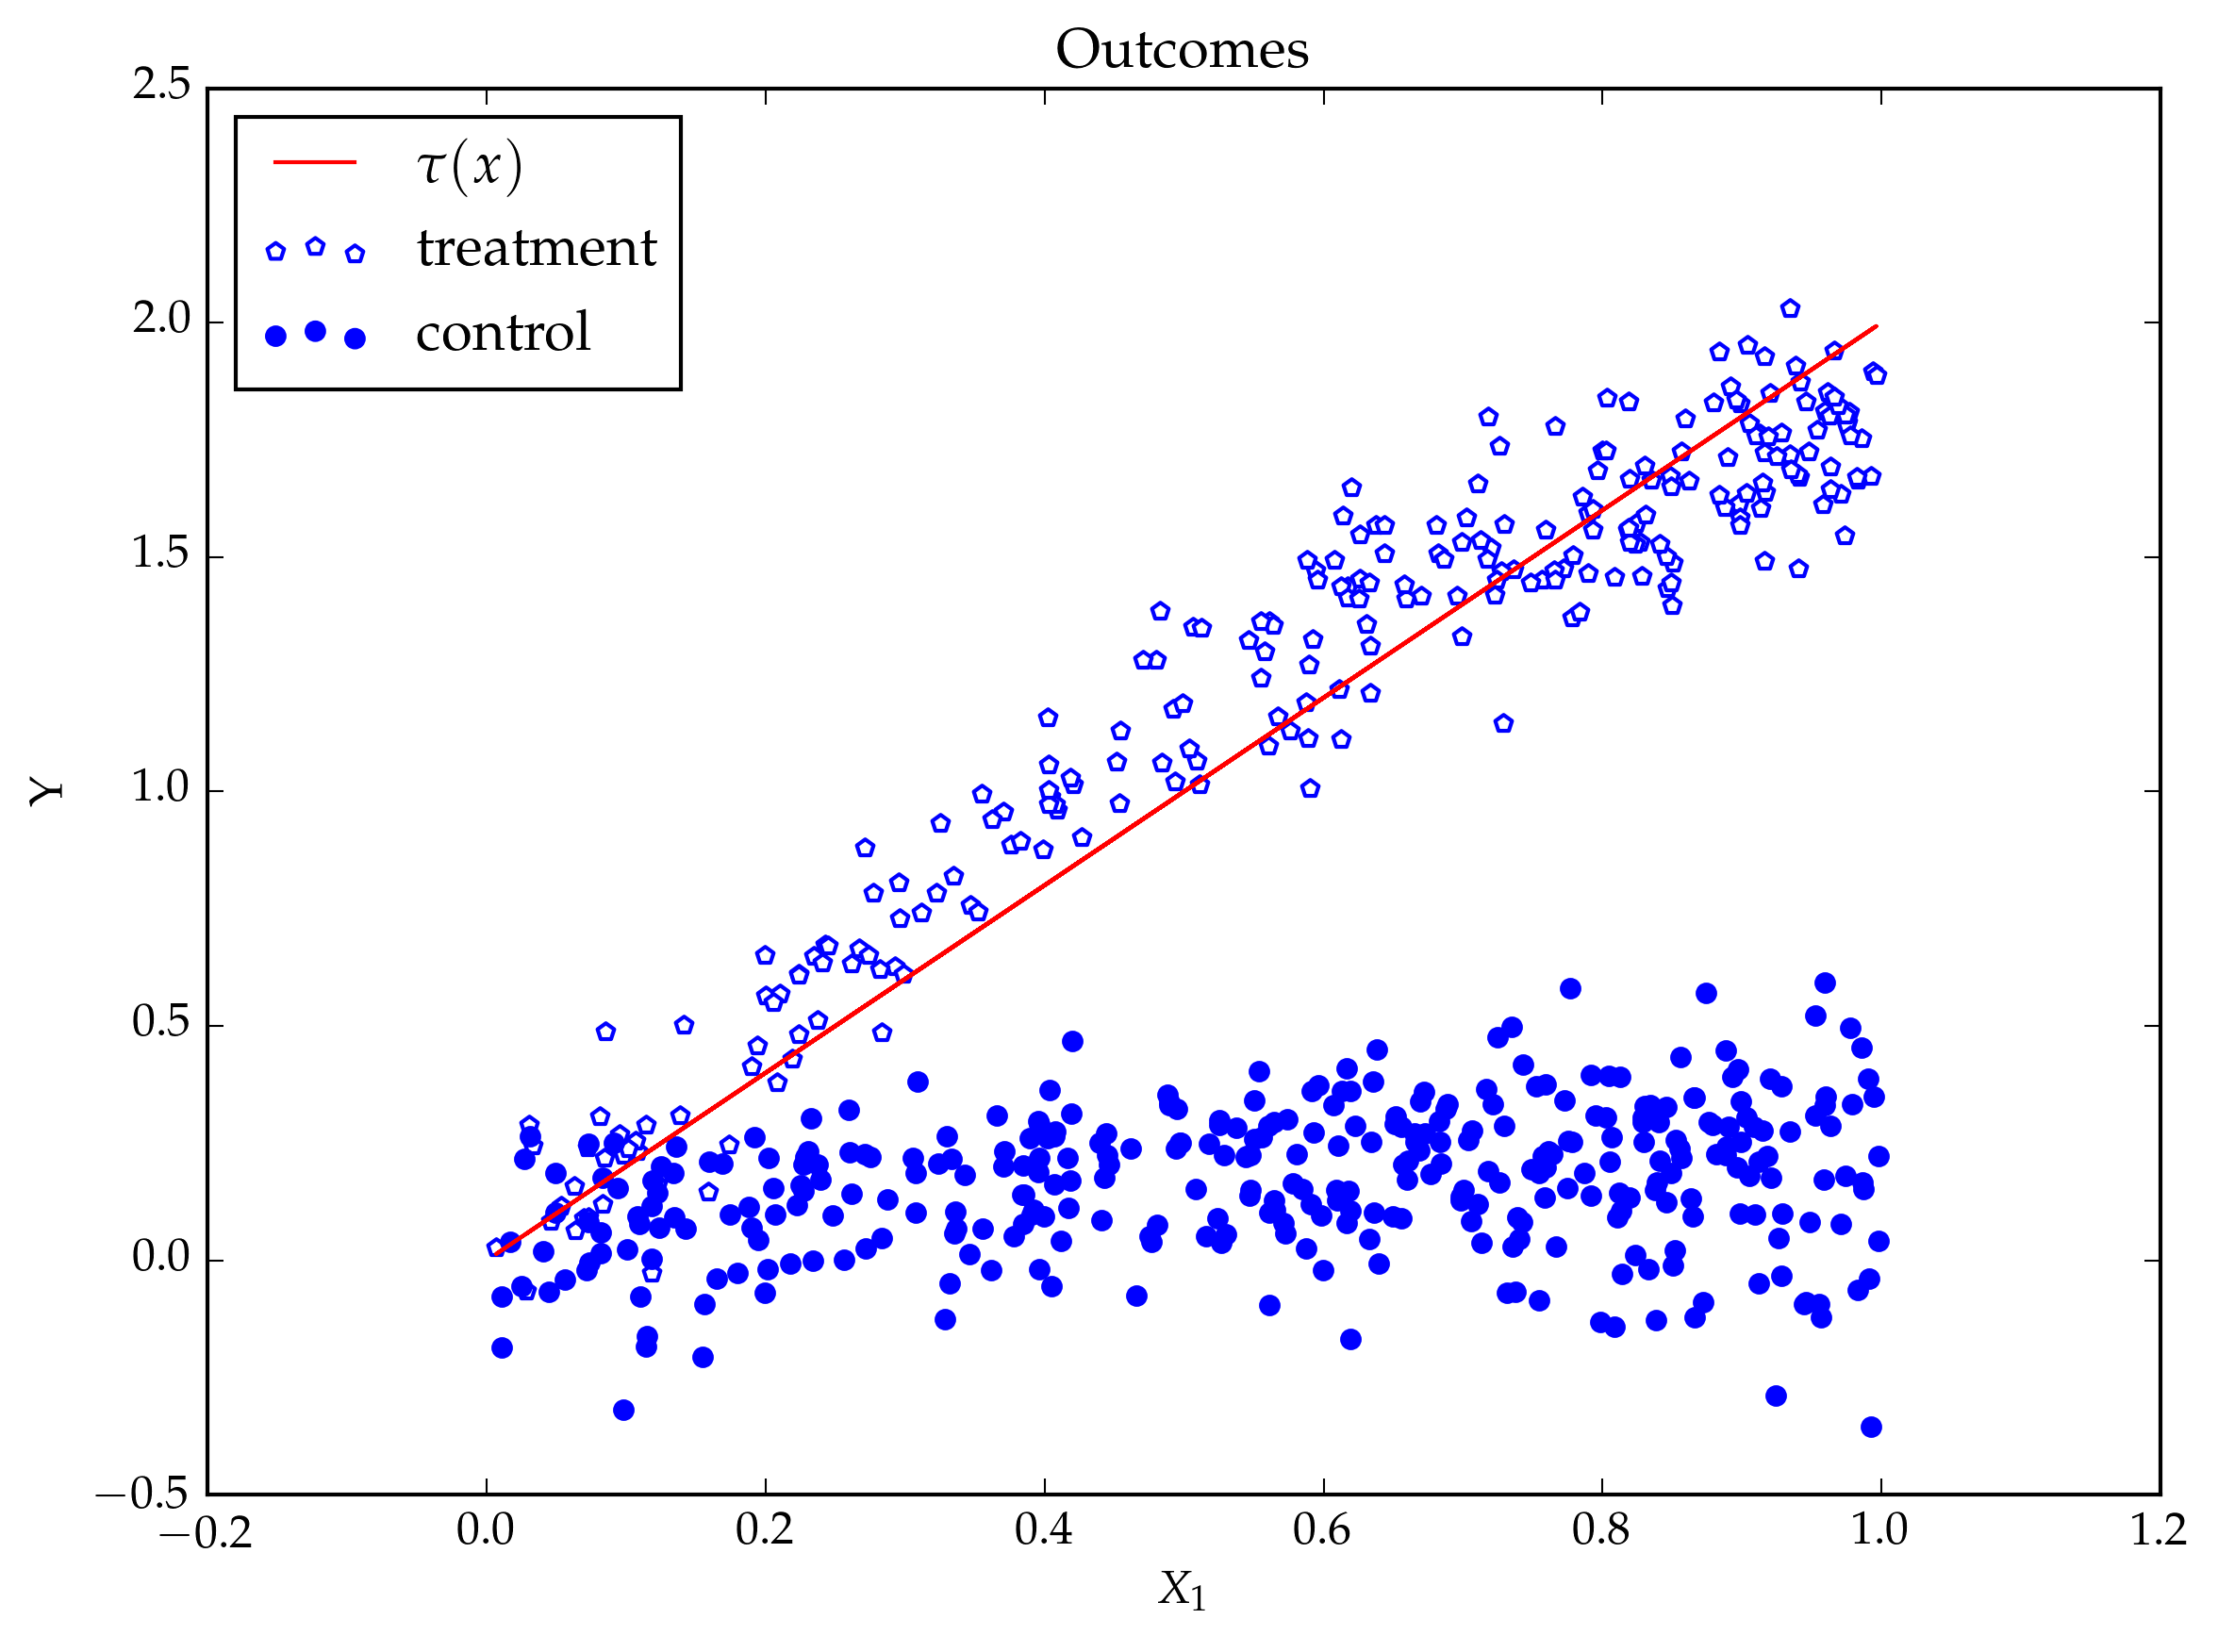

In [26]:
wb_kern = SE(log(0.5), log(0.5^2))
wb_Σprior=GaussianProcesses.cov(wb_kern, [wbX_treat wbX_ctrol])
wb_μprior=zeros(wb_n)
wb_Σobs=copy(wb_Σprior)
wb_σy2 = 0.1^2
for i in 1:wb_n
    wb_Σobs[i,i] += wb_σy2
end
wb_prior=MultivariateNormal(wb_μprior,wb_Σobs)
wb_Y=rand(wb_prior)
wb_treat = [ones(Bool,wb_ntreat);zeros(Bool,wb_nctrol)]
wb_Y[wb_treat] .+= [wb_τx(wbX_treat[1,i]) for i in 1:wb_ntreat] # apply treatment effect
plt.scatter(vec(wbX_treat[1,:]), wb_Y[wb_treat], color="white", edgecolor="blue", marker="p", label="treatment")
plt.scatter(vec(wbX_ctrol[1,:]), wb_Y[!wb_treat], color="blue", label="control")
plt.xlabel(L"X_1")
plt.ylabel("Y")
plt.plot(vec(wbX_treat[1,:]), Float64[wb_τx(x) for x in wbX_treat[1,:]], color="red", label=L"\tau(x)")
plt.legend(loc="best")
plt.title("Outcomes")
;

A quick histogram to check that the density is what we say it is:

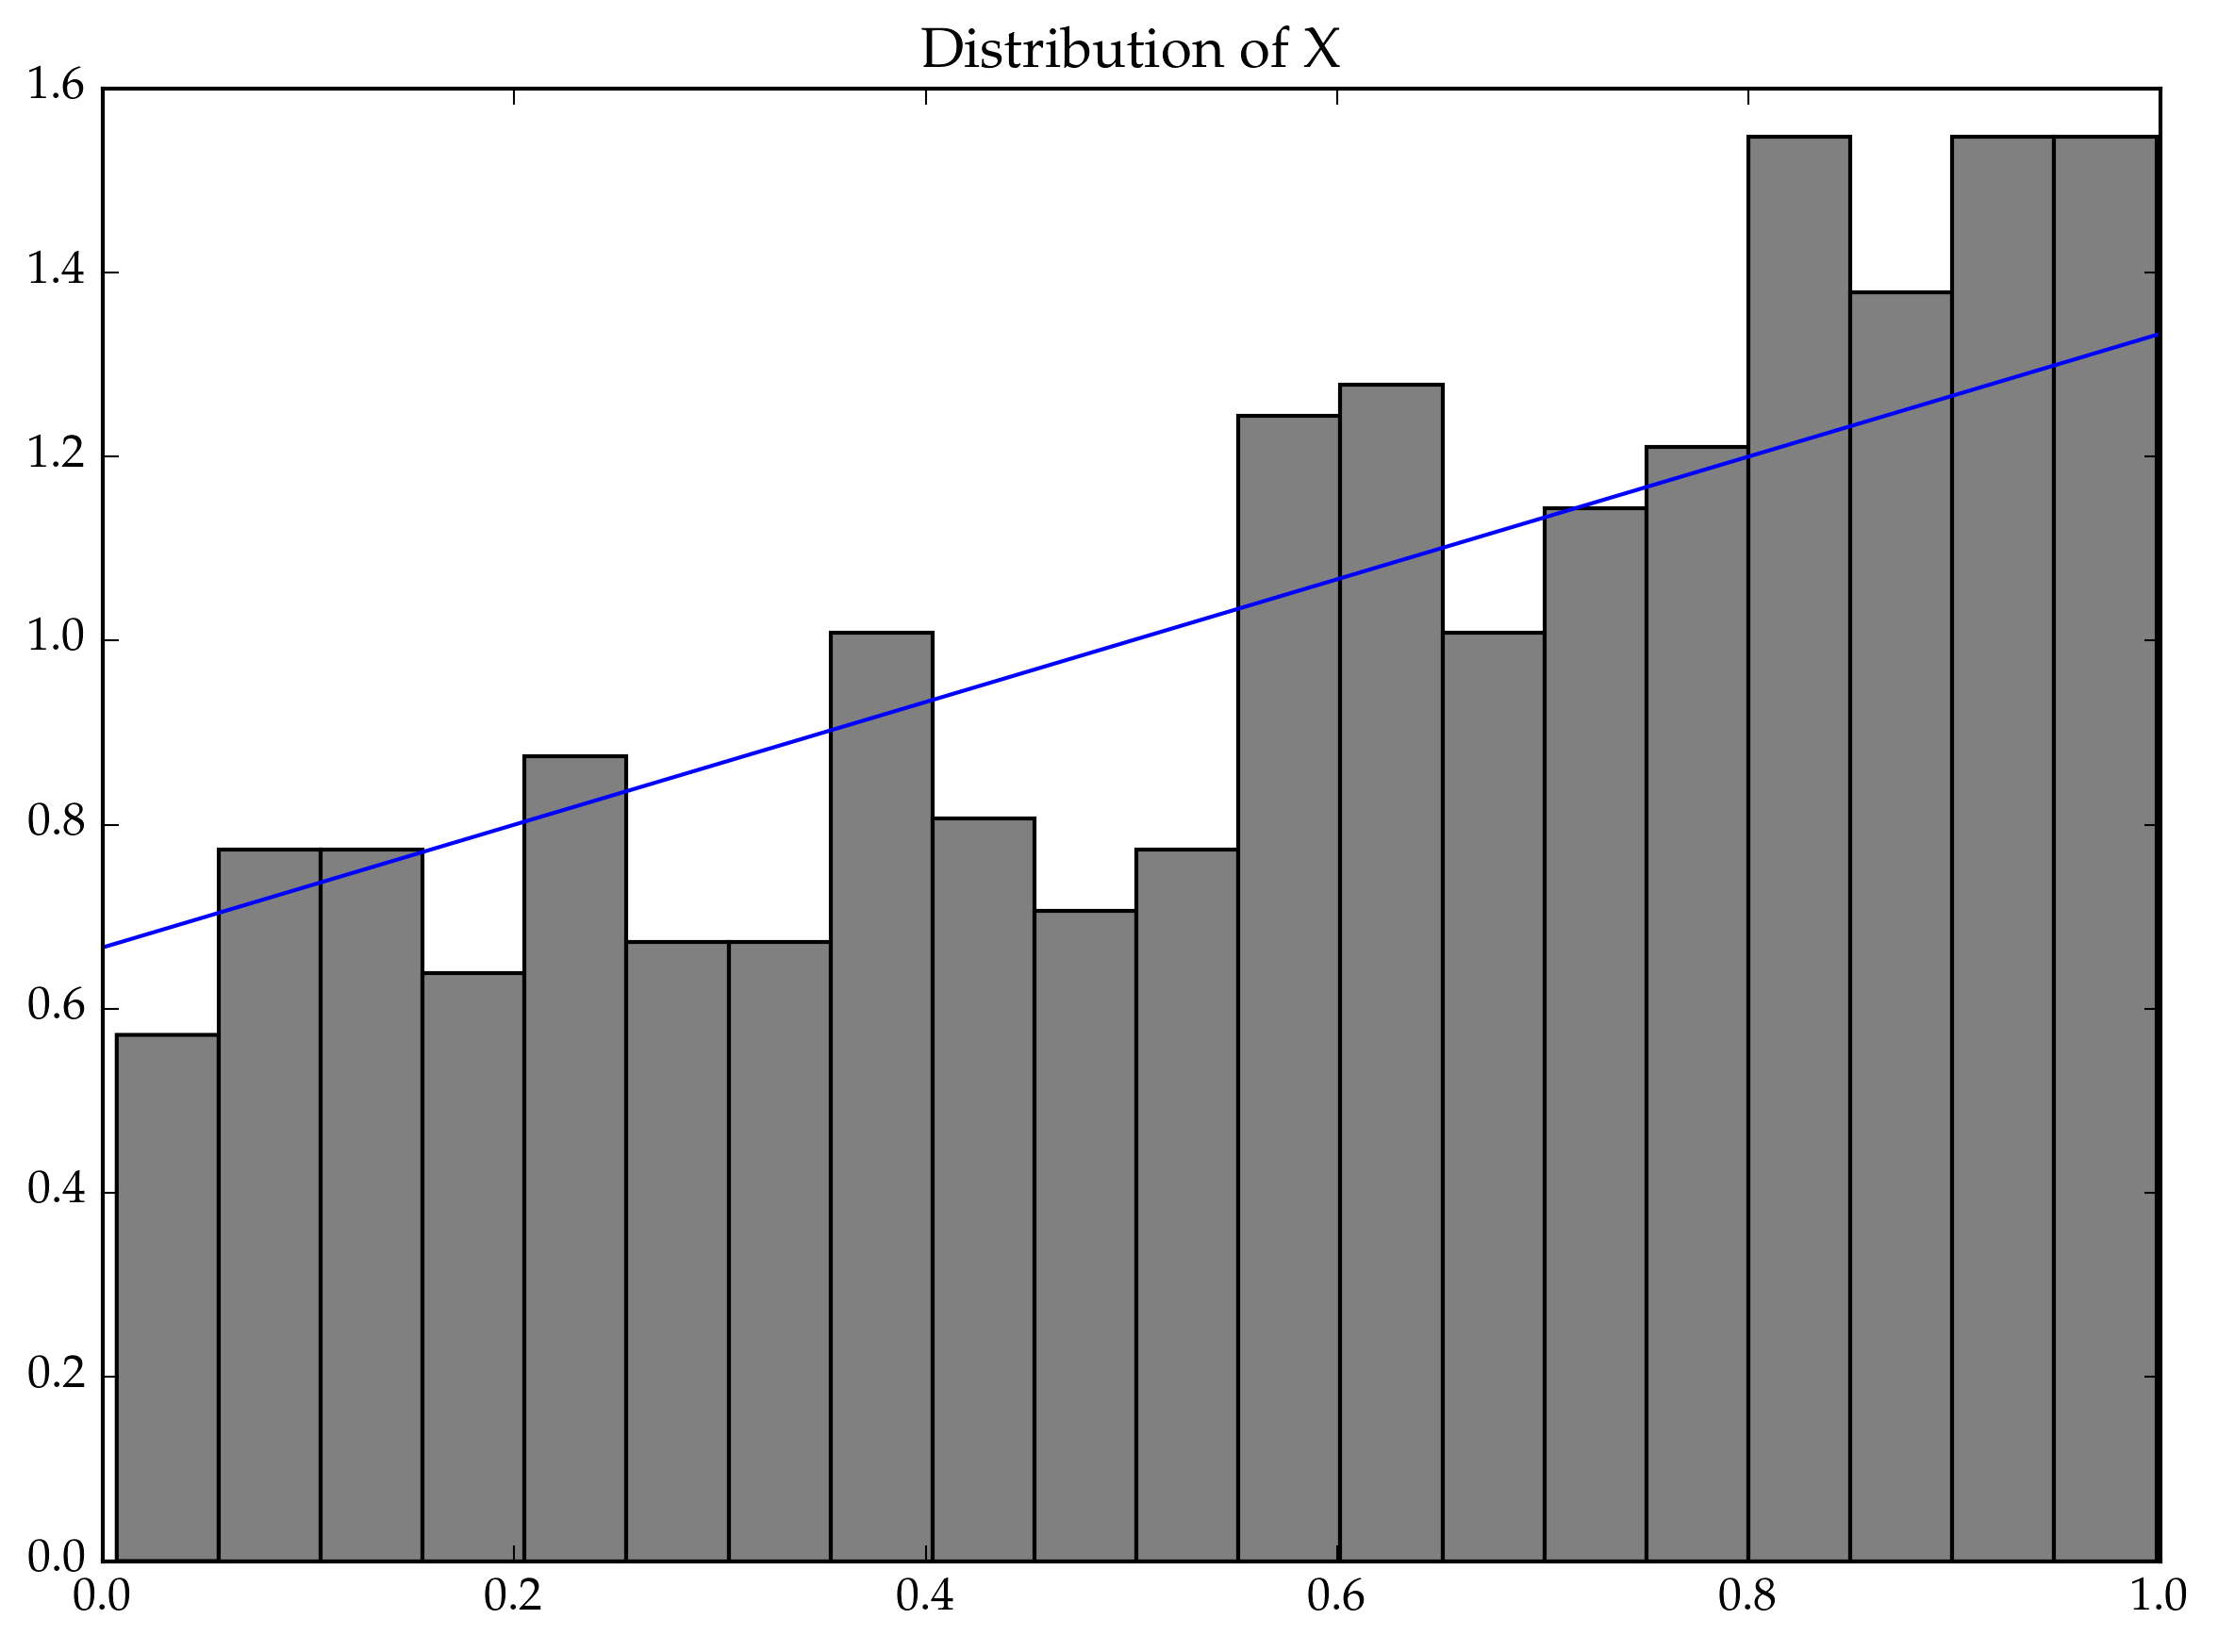

In [27]:
PyPlot.plt[:interactive](true)
plt.title("Distribution of X")
PyPlot.plt[:interactive](false)
plt.plt[:hist](vec([wbX_treat wbX_ctrol][1,:]), color="grey", bins=20, normed=true)
plt.plot([0.0,1.0],[wb_density(0.0),wb_density(1.0)]/1.5)
PyPlot.plt[:interactive](true)

Now, what are the actual simulations? I'm not actually going to touch the locations or the outcomes. The only change I am going to make is to the boundary. I am going to progressively increase the wiggliness of the left side of the boundary. The boundary grid points are always going to be equidistant, with $\Delta x = 0.01$ between points. That means that as the wiggliness increases, so does the number of boundary grid points.

The function `wb_estimators` below obtains the boundary grid points, generates GP predictions at those points from the treatment and control fitted GPs that were pre-computed, computes the posterior mean and variance of the difference at the boundary points, and then applies the three estimators of interest:

1. unweighted
2. inverse-variance weighted
3. density-weighted

We then show the estimate and credible intervals as a function of the number of wiggles between $x=0$ and $x=0.5$.

In [30]:
wb_fit_treat = GP(wbX_treat, wb_Y[wb_treat],  MeanZero(), wb_kern, log(wb_σy2))
wb_fit_ctrol = GP(wbX_ctrol, wb_Y[!wb_treat], MeanZero(), wb_kern, log(wb_σy2))
function wb_estimators(nwiggles::Int)
    l = 0.5/nwiggles
    sentinels = Float64[0:(0.01/sqrt(1+(2wb_A/l)^2)):0.5 ; 0.5:0.01:1.0]
    n◫ = length(sentinels)
    stnl_ρ = Float64[wb_density(x) for x in sentinels]
    X◫ = Float64[sentinels [boundary(x, l, wb_A) for x in sentinels]]'

    pred_treat = predict(wb_fit_treat, X◫; full_cov=true)
    pred_ctrol = predict(wb_fit_ctrol, X◫; full_cov=true)
    
    μpost = pred_treat[1].-pred_ctrol[1]
    Σpost = pred_treat[2].mat .+ pred_ctrol[2].mat
    
    τhat_unweighted = sum(μpost)/n◫
    Vτhat_unweighted = sum(Σpost)/n◫^2
    unweighted = Normal(τhat_unweighted, √Vτhat_unweighted)
    
    denom_weighted = dot(ones(n◫),(Σpost \ ones(n◫)))
    τhat_weighted = sum(Σpost\μpost) / denom_weighted
    Vτhat_weighted = 1/denom_weighted
    invvariance = Normal(τhat_weighted, √Vτhat_weighted)

    density_weights = StatsBase.WeightVec(stnl_ρ)
    τhat_density = mean(μpost, density_weights)
    Vτhat_density = dot(values(density_weights), Σpost*values(density_weights))/sum(density_weights)^2
    densityw = Normal(τhat_density, √Vτhat_density)
    return (unweighted, invvariance, densityw)
end

wb_estimators (generic function with 1 method)

In [31]:
# compute estimates
wb_nwiggles = [1, 5, 10, 50, 100, 500]
wb_estimates = [wb_estimators(n) for n in wb_nwiggles]
;

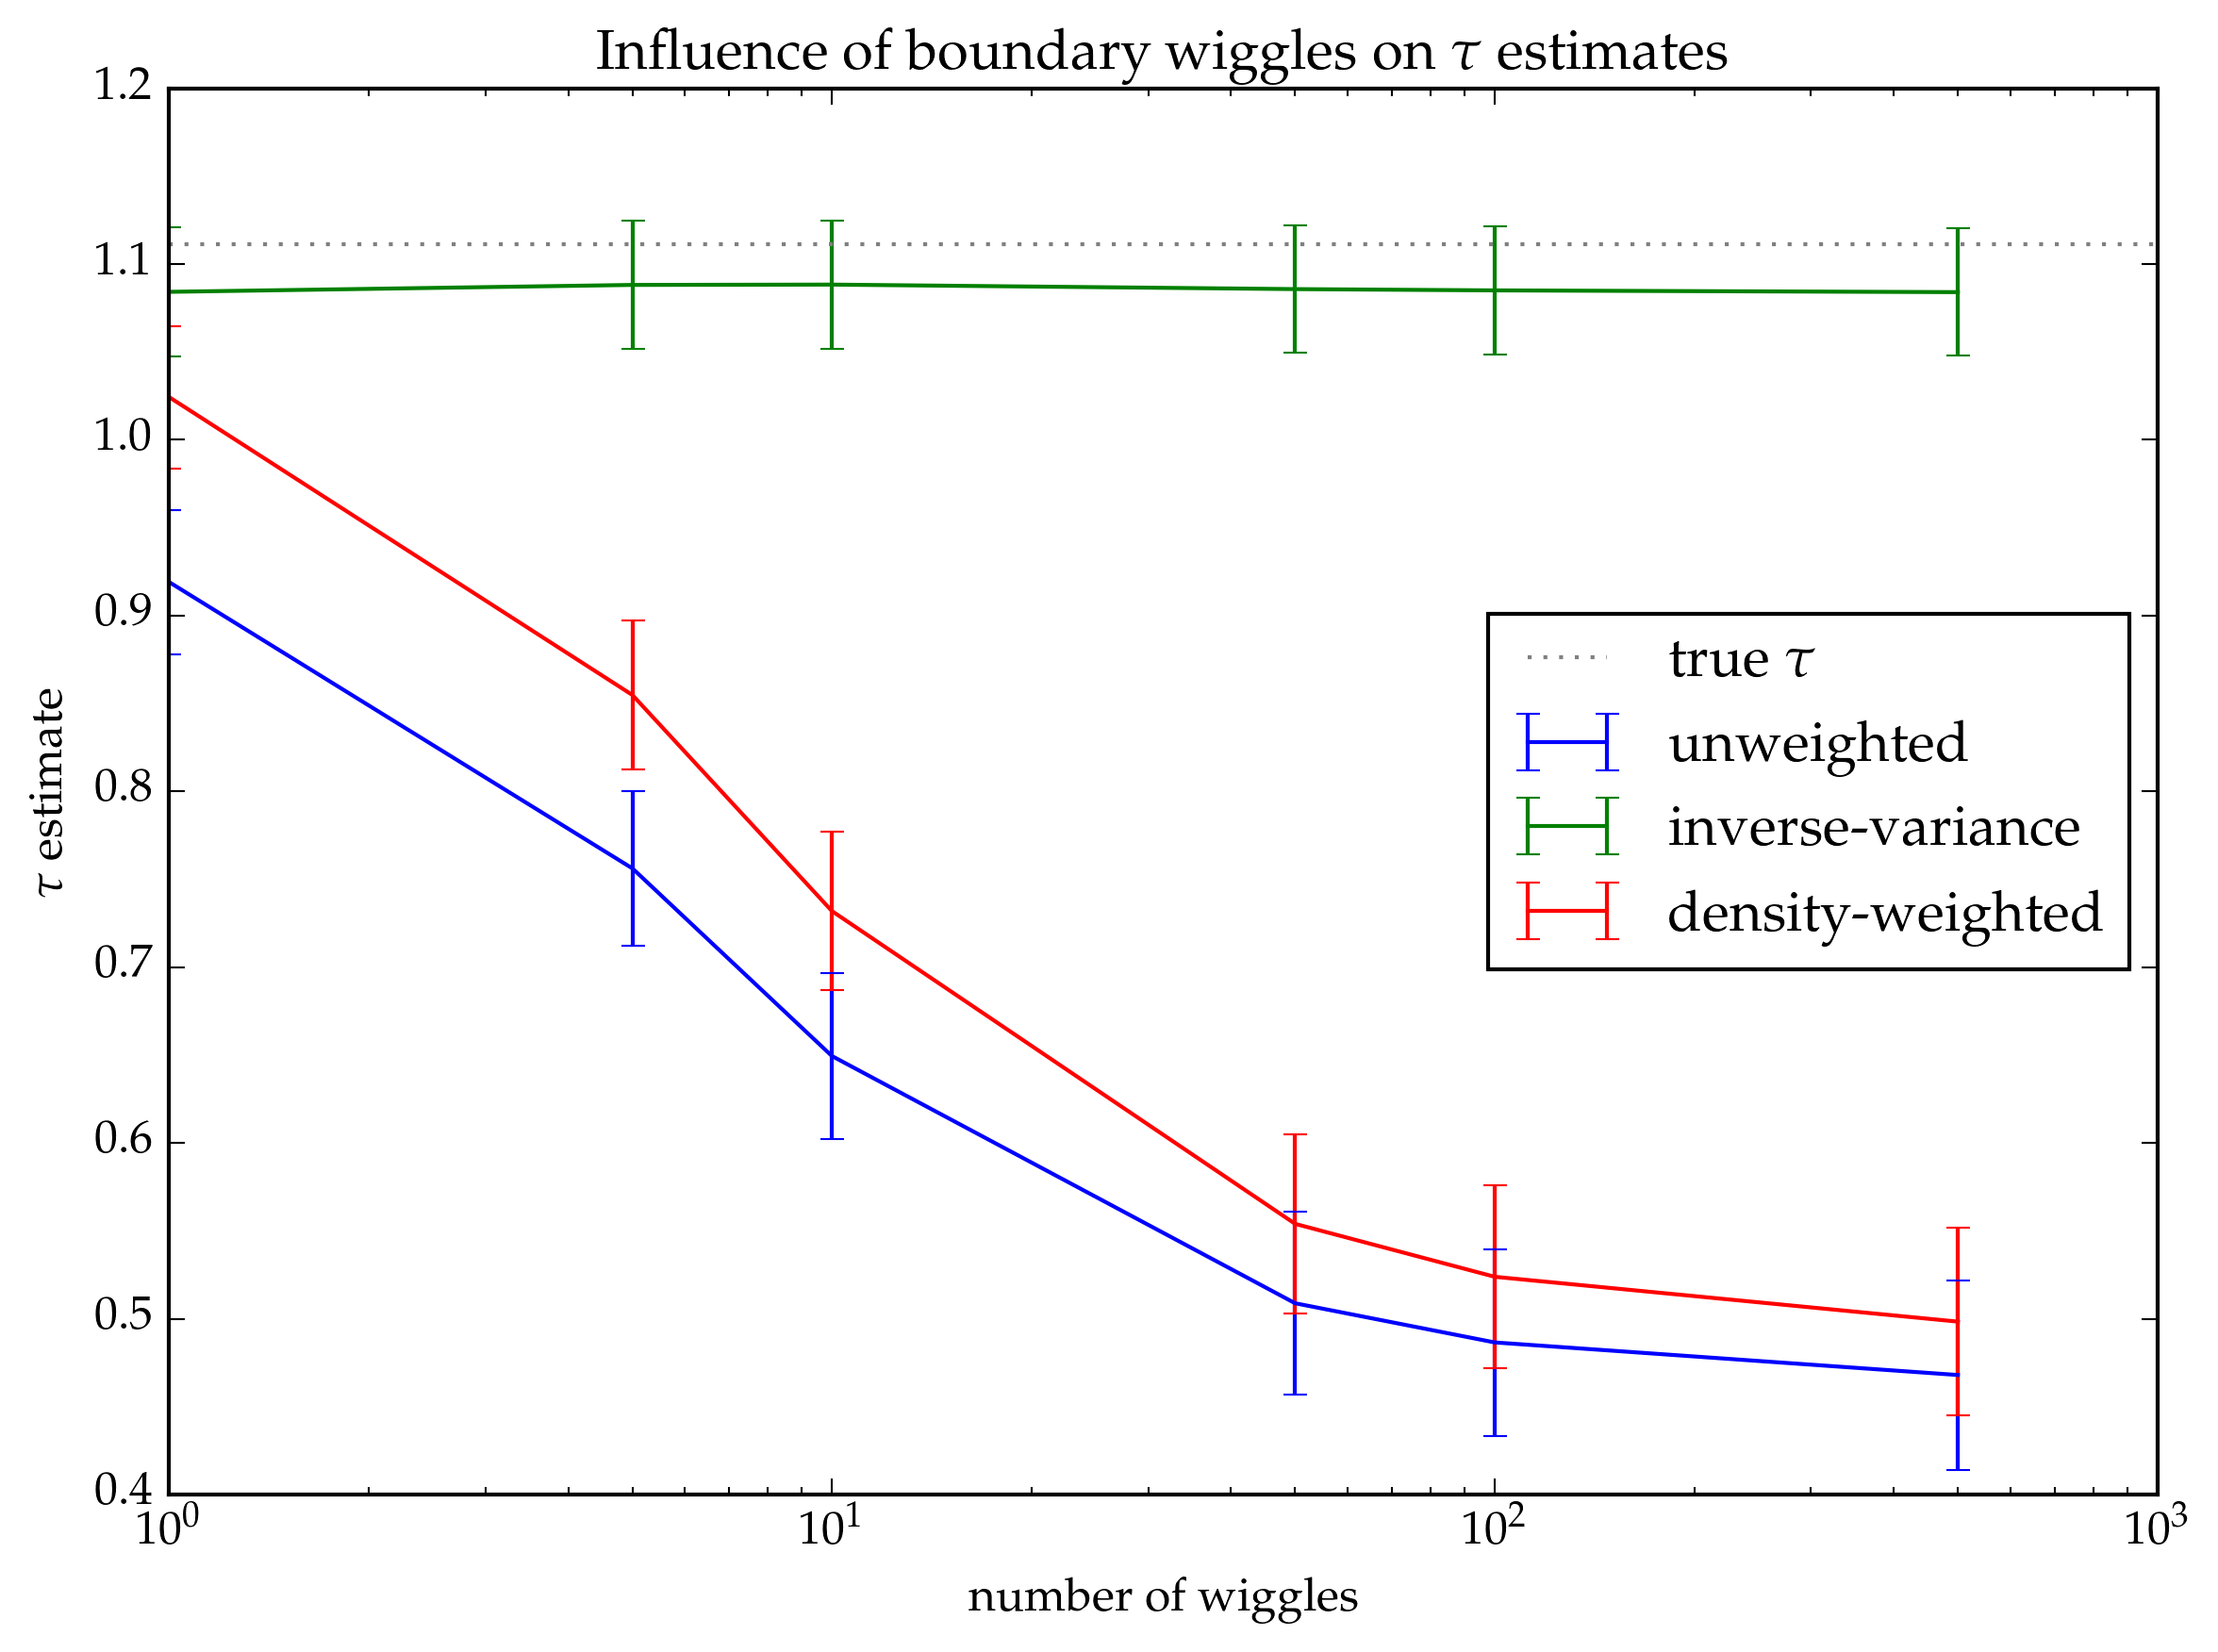

In [32]:
PyPlot.plt[:interactive](true)
plt.title(L"Influence of boundary wiggles on $\tau$ estimates")
PyPlot.plt[:interactive](false)
plt.errorbar(wb_nwiggles, 
    [mean(wbe[1]) for wbe in wb_estimates], 
    yerr=[std(wbe[1]) for wbe in wb_estimates], 
    label="unweighted")
plt.errorbar(wb_nwiggles, 
    [mean(wbe[2]) for wbe in wb_estimates], 
    yerr=[std(wbe[2]) for wbe in wb_estimates], 
    label="inverse-variance")
plt.errorbar(wb_nwiggles, 
    [mean(wbe[3]) for wbe in wb_estimates], 
    yerr=[std(wbe[3]) for wbe in wb_estimates], 
    label="density-weighted")    
plt.xlabel("number of wiggles")
plt.ylabel(L"$\tau$ estimate")
plt.gca()[:set_xscale]("log")
plt.axhline(wb_τtrue, label=L"true $\tau$", color="grey", linestyle=":")
plt.legend(loc="best")
PyPlot.plt[:interactive](true)
;

First a quick table to remind us of the simulation setup.

|                    | Left   | Right    |
|-------------------:|--------|----------|
|       **Boundary** | wiggly | straight |
|        **Density** | low    | high     |
| $\mathbf{\tau(x)}$ | small  | large    |

In the plot, we see the effect very clearly: when there is only one wiggle, the inverse-variance and density-weighted estimates are in pretty close agreement, close to the true value of $\tau$. The unweighted estimator gives more weight to the left (less dense) region, which also has lower $\tau(x)$, leading to a lower $\hat\tau$ estimate. But as more wiggles get added, and hence more grid points are added to the left (wiggly) region, the unweighted and density-weighted estimates systematically give more weight to the left region, and hence the estimates go down. Meanwhile, the inverse-variance estimator, because it takes the covariance structure into account, is not susceptible to this issue.

Obviously, the extremely wiggly boundary is unrealistic in most situations, but this does highlight an undesirable feature of the density-weighted estimator. Another manifestation of this issue is that the estimate changes if the gridpoints aren't evenly spaced.

## Attempt at synthesis

We can think of this problem as deciding where to place sentinel units, whose potential outcomes we will impute, and then average the differences. The finite population idea is that the sentinels should just be the population, but we have seen that that doesn't work well. My intuition is that we should put more sentinels where we have more information. As in the classical RDD setting, we only have information at the boundary, so the sentinels should all be at the boundary. This is something that Zach pointed out. In the RDD literature, the estimand is a *limit* of two expectations at the boundary. He cited Imben&Lemieux's “
Regression Discontinuity Designs: A Guide to Practice”, which defines the estimand thus:
> In the SRD design we look at the discontinuity in the conditional expectation of the outcome given the covariate to uncover an average causal effect of the treatment:
$$ lim_{x\downarrow c} \E \sbr{ Y-I \mid X_i = x} - lim_{x\uparrow c} \E \sbr{ Y-I \mid X_i = x}$$
> which is interpreted as the average causal effect of the treatment at the discontinuity point:
$$ \tau_{SRD} = \E\sbr{Y_i(1) - Y_i(0) \mid X_i =c }$$

Therefore the estimand is strictly a causal effect at the boundary. I think our group opinion so far has been that that should also be a feature/limitation of our spatial RDD methods.

In our meeting I brought up the image of the boundary going through a lake. What does it mean to have a treatment effect across the boundary on this lake? Here, the finite population approach, and the density-weighted approach make complete sense: nobody lives on the lake, so we put no sentinels there. In the inverse variance scheme, there are a few sentinels along the boundary on the lake because of the prior (the variance doesn't go to infinity). In the distance-averaged scheme, there are just as many sentinels on the lake as in dense metropolitan areas. I think we can all agree that that isn't very sensible.

I think Zach's point is this: let the practicioner decide where she wants to put her sentinels.

LukeB had an interesting comment about this, connecting the inverse variance estimator to the concept of preferential treatment in spatial statistics. I couldn't find a source that explains this, but my understanding is that preferential treatment is something we would worry about if the sampling is very uneven geographically. Regions with more measurements get more of a say in the final analysis, which can skew the results. He pointed out that in contrast to traditional spatial statistics, here this could be a feature rather than a bug, since we probably actually want to give more weight to parts of the boundary that are more densely populated. LukeB, I'd be interested to hear from you, if this is what you meant by that comment.

I think our final recommendation should be the inverse-variance estimator, but we should use the density-weighted estimator to provide motivation, intuition, and justification of the inverse-variance approach.

# Hypothesis testing (failed idea)

What if we want to test the hypothesis that $\tau(x)=0 ~ \forall x$? One idea is to evaluate the PDF of the posterior $\tau(x)$ at zero, and compare it to the distribution of the PDF under the posterior distribution. The problem is that $\Sigma^{post}$ is not necessarily numerically positive definite:

In [33]:
posteriorτx = MultivariateNormal(μposterior, Σposterior)

FullNormal(
dim: 120
μ: [1.90394,1.97277,2.03864,2.0998,2.15458,2.2015,2.23939,2.26747,2.28541,2.29341  …  1.38462,1.4227,1.46673,1.51656,1.57187,1.63215,1.69663,1.7643,1.8339,1.90394]
Σ: 120x120 Array{Float64,2}:
 0.667009  0.663353  0.652576  0.635005  …  0.652598  0.663404  0.667009
 0.663353  0.665599  0.660711  0.648862     0.637722  0.653991  0.663353
 0.652576  0.660711  0.661871  0.656066     0.616251  0.637638  0.652576
 0.635005  0.648862  0.656066  0.656469     0.588784  0.614818  0.635005
 0.611145  0.630406  0.643491  0.650096     0.556064  0.586166  0.611145
 0.581654  0.605866  0.624514  0.637152  …  0.518949  0.552453  0.581654
 0.547319  0.575912  0.599663  0.618004     0.478379  0.514557  0.547319
 0.509024  0.541331  0.569605  0.593174     0.435343  0.473431  0.509024
 0.467722  0.503004  0.535119  0.563316     0.390842  0.430065  0.467722
 0.424394  0.461868  0.497067  0.529189     0.345856  0.385457  0.424394
 0.380021  0.418887  0.456367  0.491635  …  0.301318  0.

That's because numerically, $\Sigma^{post}$ has some negative eigenvalues:

In [37]:
eigmin(Σposterior)

3.8704492608088826e-9

Hacky solution: add enough weight on the diagonal of $\Sigma^{post}$ so the eigenvalues are positive.

In [39]:
Σposdef = Σposterior.mat .+ (0.01+abs(min(eigmin(Σposterior),0.0))).*eye(n◫)
eigmin(Σposdef)

0.010000003870449234

In [40]:
posteriorτx = MultivariateNormal(μposterior, Σposdef)
pdf0 = logpdf(posteriorτx, zeros(Float64, n◫))
pdfμ = logpdf(posteriorτx, μposterior)
pdfsamples = Float64[logpdf(posteriorτx, rand(posteriorτx)) for _ in 1:10000]
;

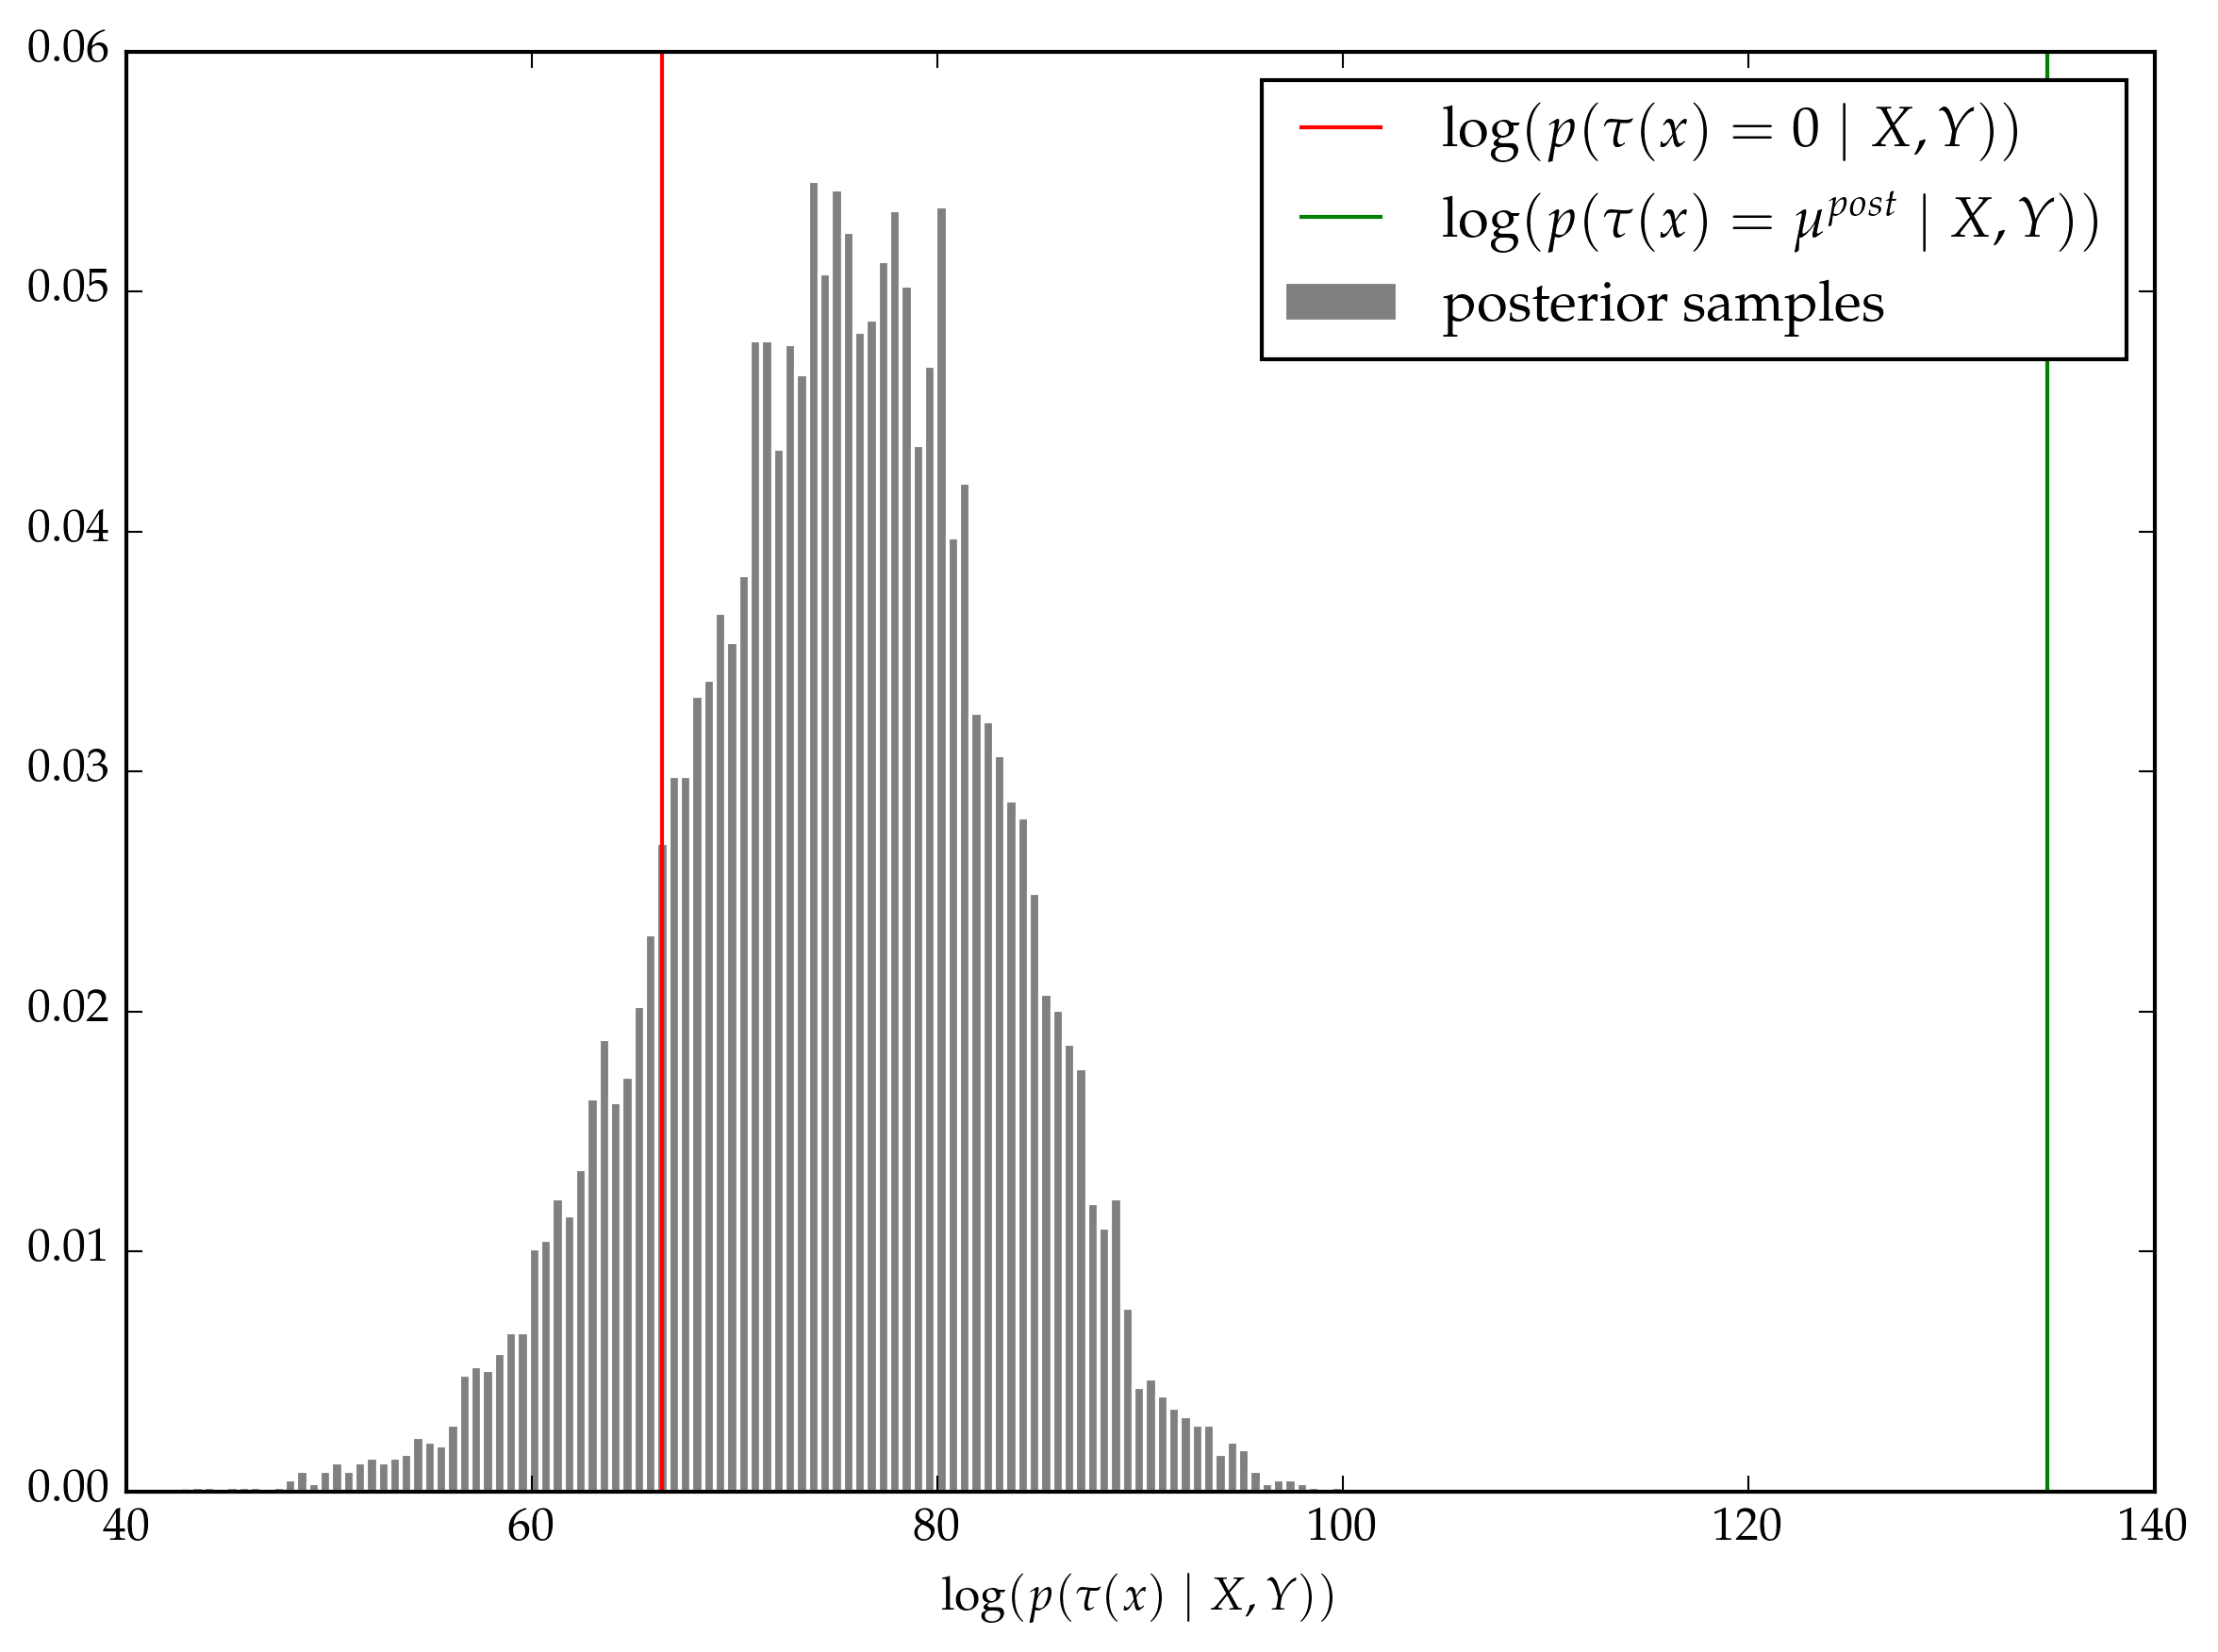

In [41]:
plt.plt[:interactive](true)
plt.axvline(pdf0, color="red", label=L"\log(p(\tau(x)=0 \mid X,Y))")
plt.plt[:interactive](false)
plt.axvline(pdfμ, color="green", label=L"\log(p(\tau(x)=\mu^{post} \mid X,Y))")
plt.plt[:hist](pdfsamples, bins=100, normed=true, color="grey", edgecolor="white", label="posterior samples")
plt.legend(loc="best")
# plt.xlim(-0.1,pdf0+0.1)
plt.xlabel(L"\log(p(\tau(x) \mid X,Y))")
plt.plt[:interactive](true)

**Conclusion:** this doesn't work at all because of the curse of dimensionality. All posterior samples have much *lower* likelihood than $\vec{0}$.

# Hypothesis test using chi square test

Alessio Benavoli and Francesca Mangili have a paper on “Gaussian Processes for Bayesian hypothesis tests on regression functions”. It's not a very good paper, but one of their $\chi^2$ tests looks like it could be applicable here. From section 3, “equality tests”, we should follow the following procedure. First, following their equation 11, compute
$$ \mu^\intercal \Sigma^{-1} \mu $$
and compare it to $\chi^2_\nu(1-\alpha)$ where $\nu$ is the number of positive eigenvalues of $\Sigma$. Because of the numerical instability of the eigenvalues, this is ill-defined, and they recommend counting eigenvalues that satisfy
$$\lambda_{i} \big/ \sum_{i=1}^n \lambda_i < \epsilon$$ and they use $\epsilon=0.01$. We also replace $\Sigma$ with all low eigenvalues zeroed-out.

In [42]:
function get_pval(μ::Vector{Float64}, Σ::Matrix{Float64}, ϵ::Float64)    
    Σsvd = svdfact(Σ)
    λvec = Σsvd[:S] # sorted in decreasing order
    aboveϵ = (λvec ./ sum(λvec)) .> ϵ
    ν = max(sum(aboveϵ),1)
    Sabove = Σsvd[:S][aboveϵ]
    Σsvd[:S][:] = 1./Σsvd[:S] # invert high eigenvalues
    Σsvd[:S][!aboveϵ] = 0.0 # but remove low eigenvalues
    t = dot(μ, (full(Σsvd) * μ))
    nullhypo = Chisq(ν)
    pval = ccdf(nullhypo, t)
    return pval
end

get_pval (generic function with 1 method)

The obvious problem is that the estimated $\nu$ is very sensitive to the choice of $\epsilon$. Does this affect the p-values? Let's check.

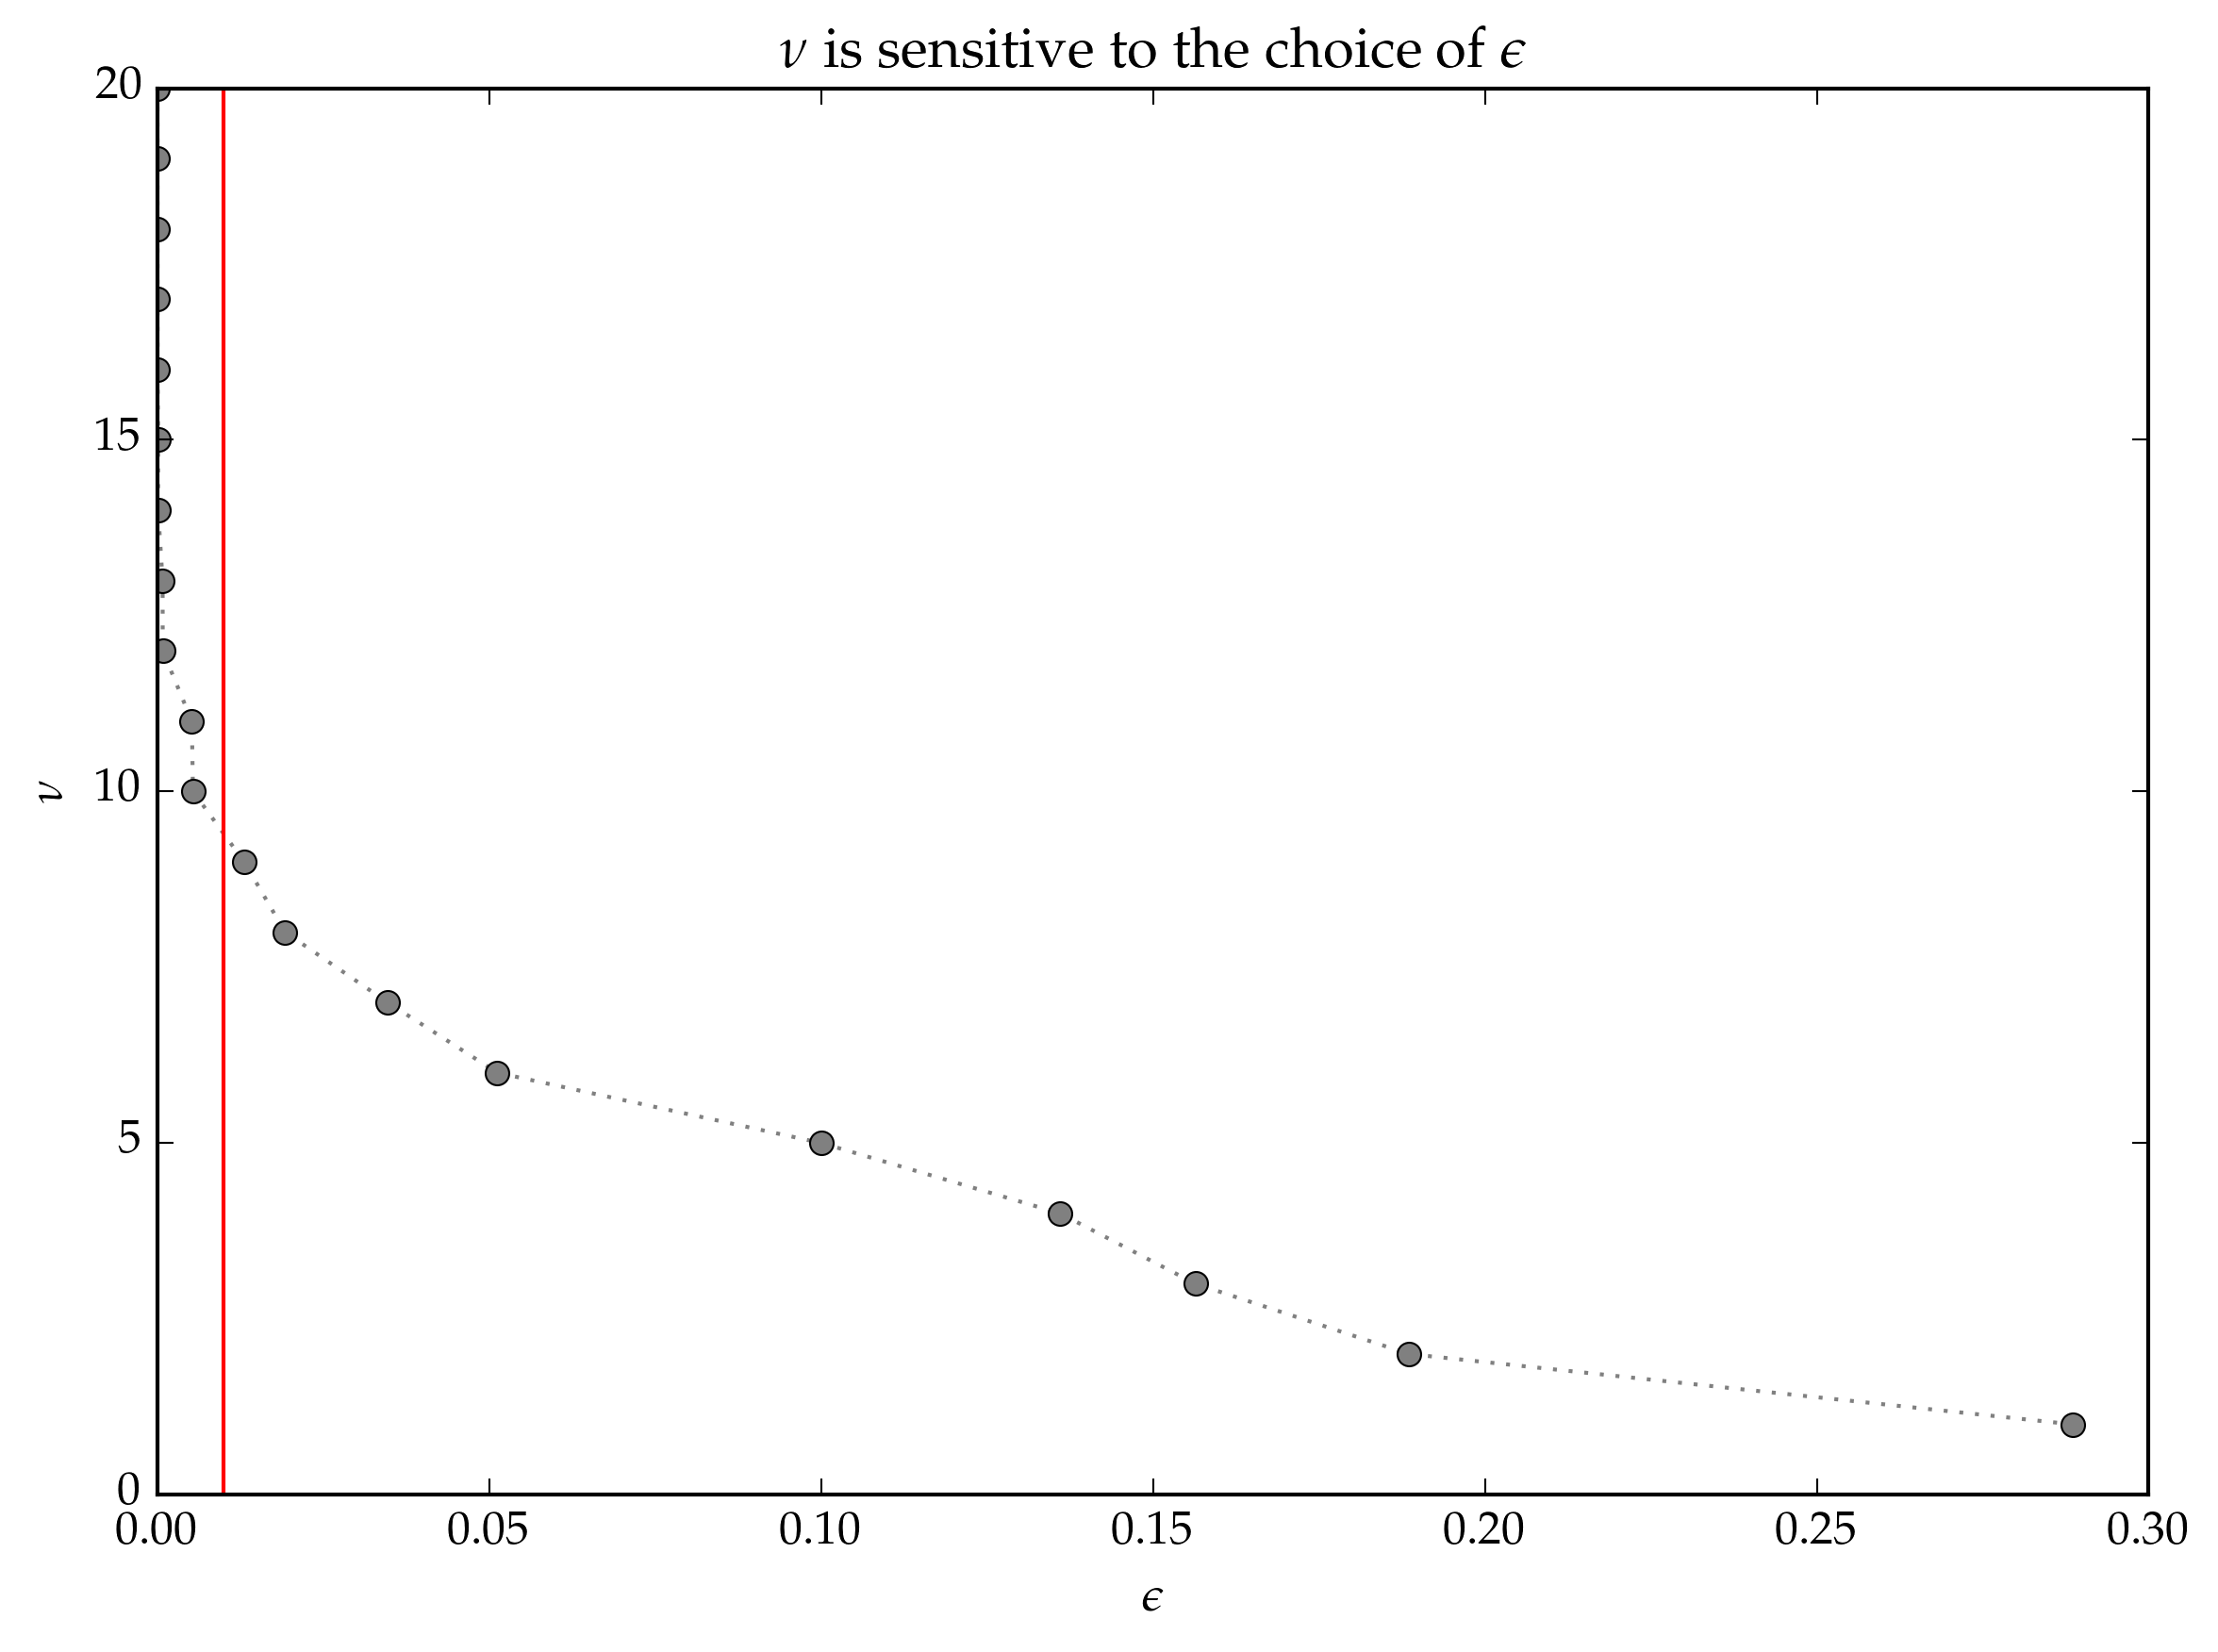

In [44]:
λvec = eigvals(Σposterior.mat)
λpos = λvec[λvec .> 0]
plt.plot(reverse(λpos ./ sum(λpos)), 1:length(λpos), ":o", color="grey")
plt.axvline(0.01, color="red")
plt.title(L"$\nu$ is sensitive to the choice of $\epsilon$")
plt.xlabel(L"\epsilon")
plt.ylabel(L"\nu")
plt.ylim(0,20)
;

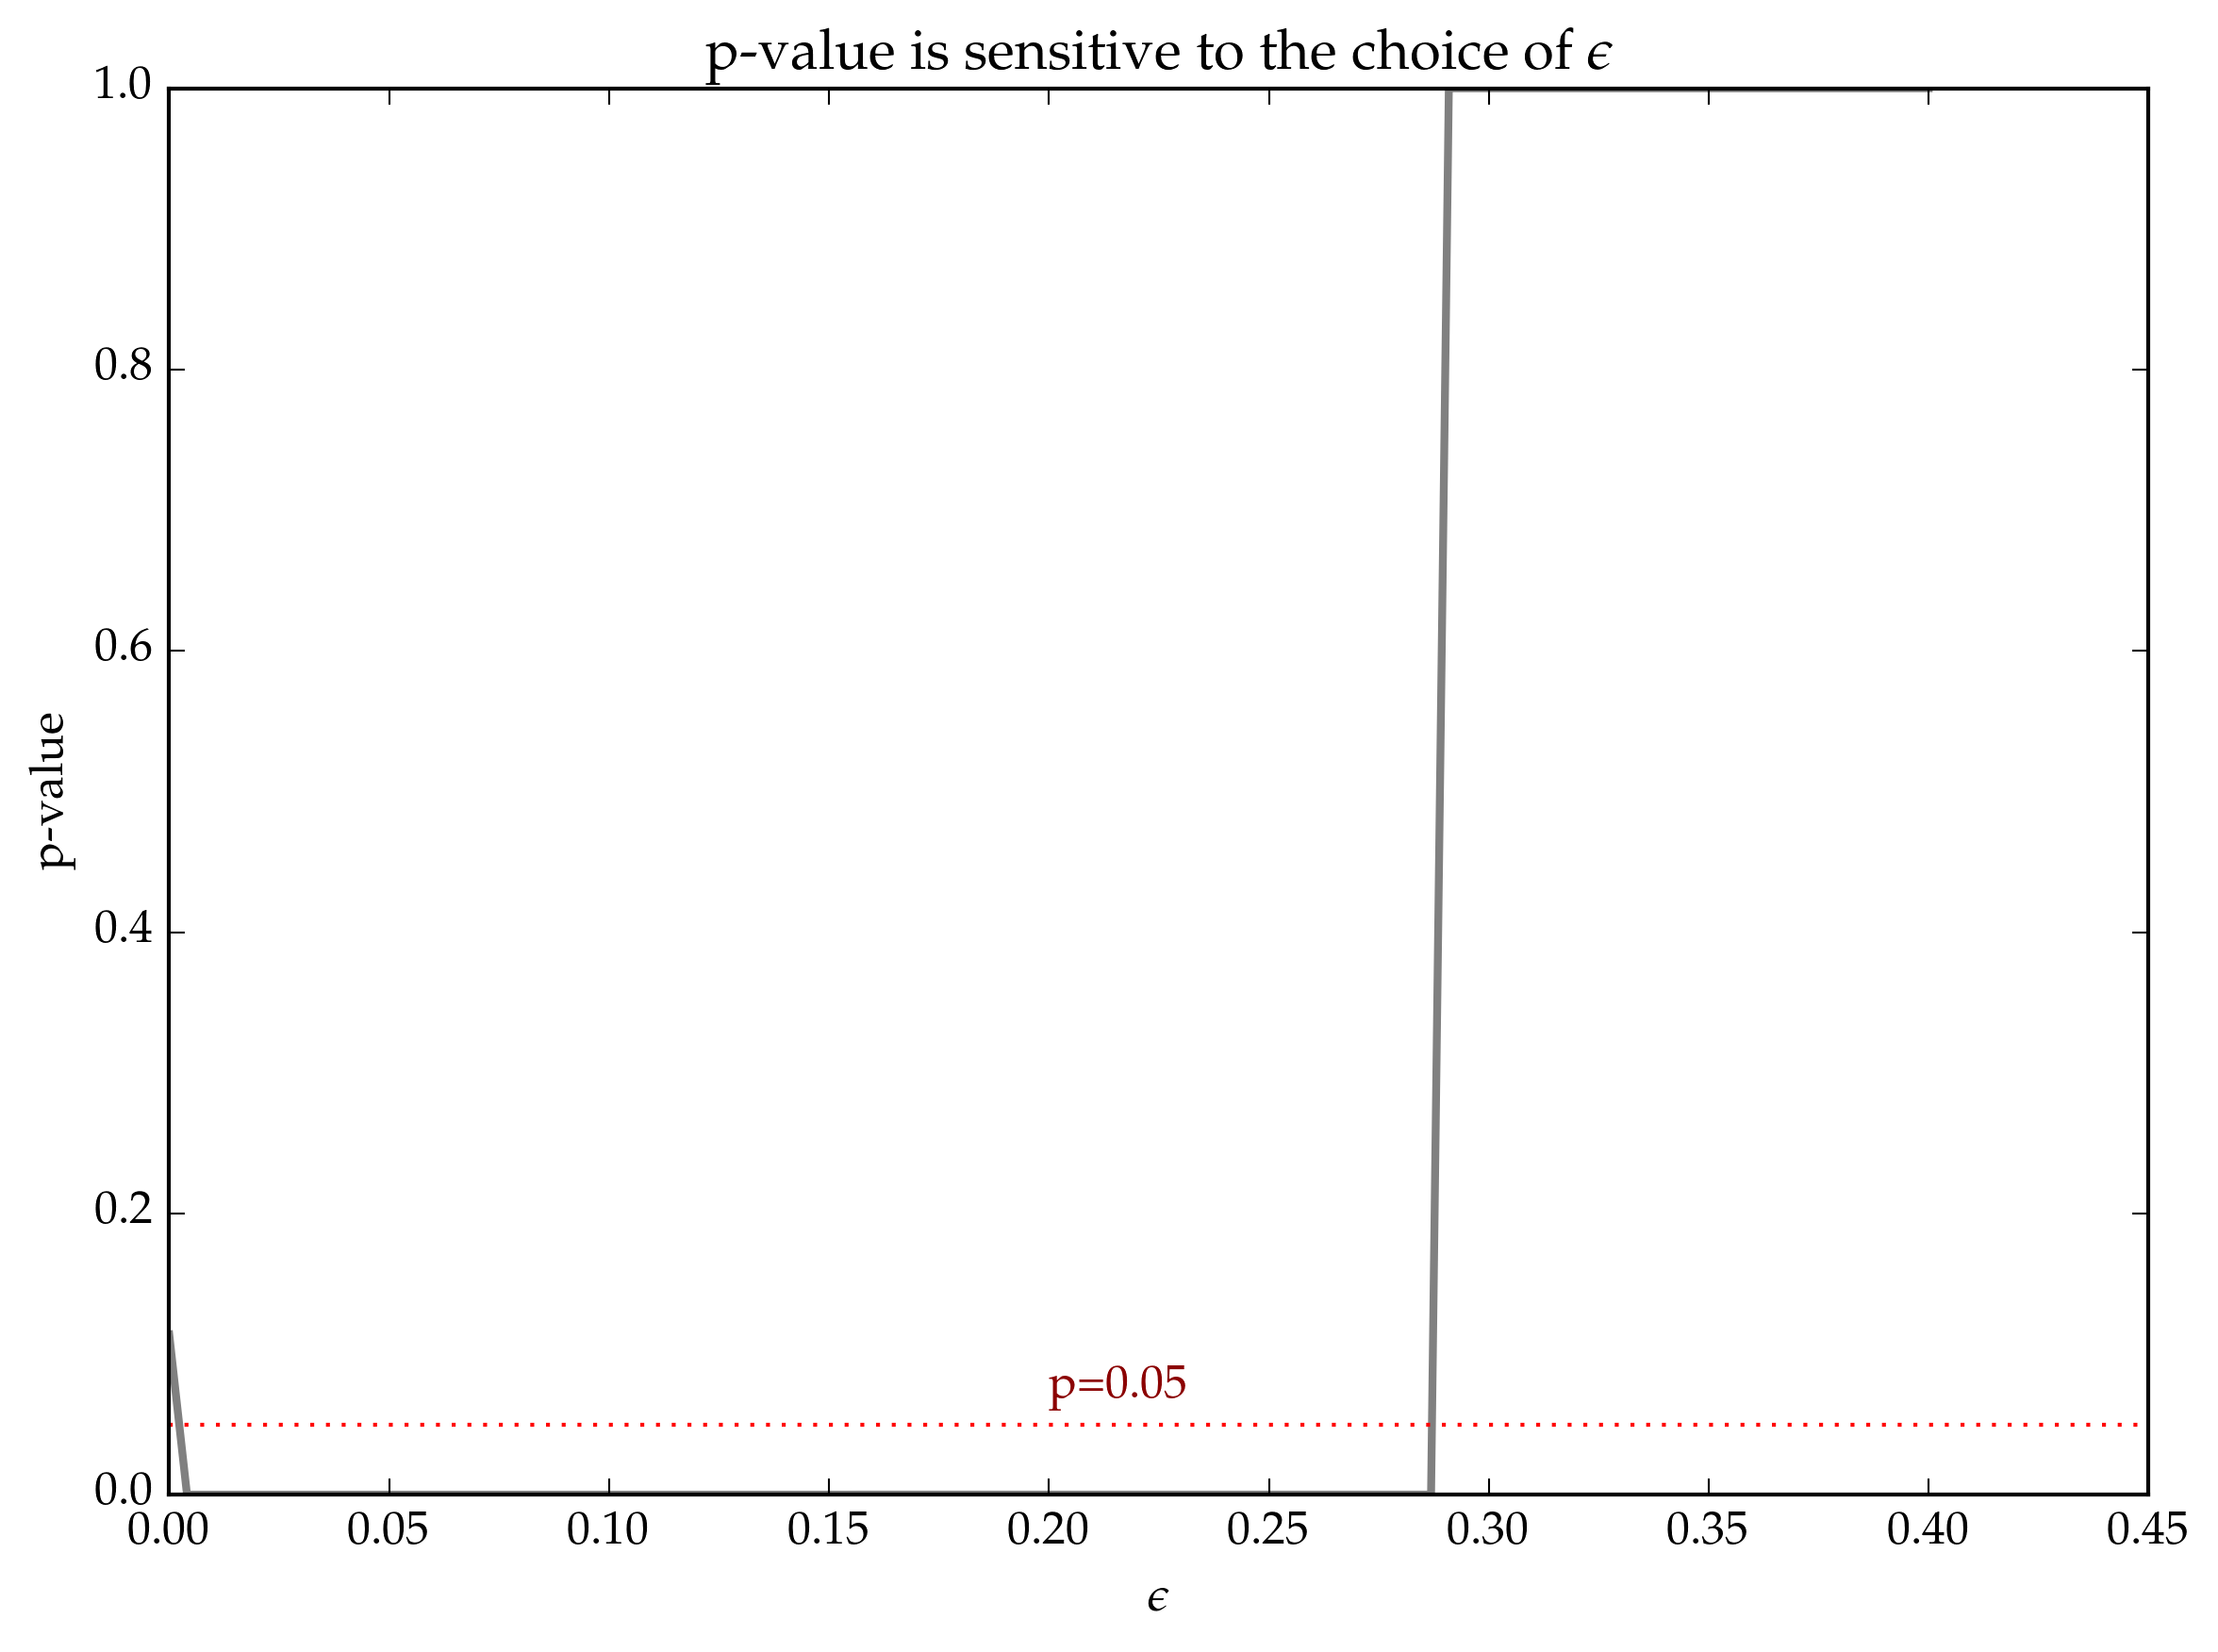

In [46]:
xϵ = linspace(0,0.4,100)
plt.plot(xϵ, [get_pval(μposterior, Σposterior.mat, ϵ) for ϵ in xϵ], "-", color="grey", linewidth=2)
plt.axhline(0.05, linestyle=":", color="red")
plt.text(x=0.2, y=0.06, s="p=0.05", color="darkred", verticalalignment="bottom")
plt.title(L"p-value is sensitive to the choice of $\epsilon$")
plt.xlabel(L"\epsilon")
plt.ylabel("p-value")
;

The fact that the p-value is quite sensitive to $\epsilon$ is a real issue. It's not always monotonic either. The derivative is particularly steep when $\epsilon$ is low, near the suggested $\epsilon=0.01$.

## p-values under the null

We'll carry on with $\epsilon=0.01$, and simulate under the null, still with locations fixed so we can re-use the Cholesky decomposition of the covariance matrix, which speeds up our simulations.

In [49]:
function sim_pval_null(ϵ::Float64)
    Ystar = rand(prior)
    gp_fit_inside.y = Ystar[inside]
    gp_fit_outside.y = Ystar[!inside]
    update_alpha!(gp_fit_inside)
    update_alpha!(gp_fit_outside)
    extrap◫_inside = predict(gp_fit_inside, X◫; full_cov=true)
    extrap◫_outside = predict(gp_fit_outside, X◫; full_cov=true)
    μpost = extrap◫_inside[1].-extrap◫_outside[1]
    Σpost = extrap◫_inside[2]+extrap◫_outside[2]
    return get_pval(μpost, Σpost.mat, ϵ)
end

sim_pval_null (generic function with 1 method)

In [50]:
pvalues_null = Float64[sim_pval_null(0.01) for _ in 1:10000];

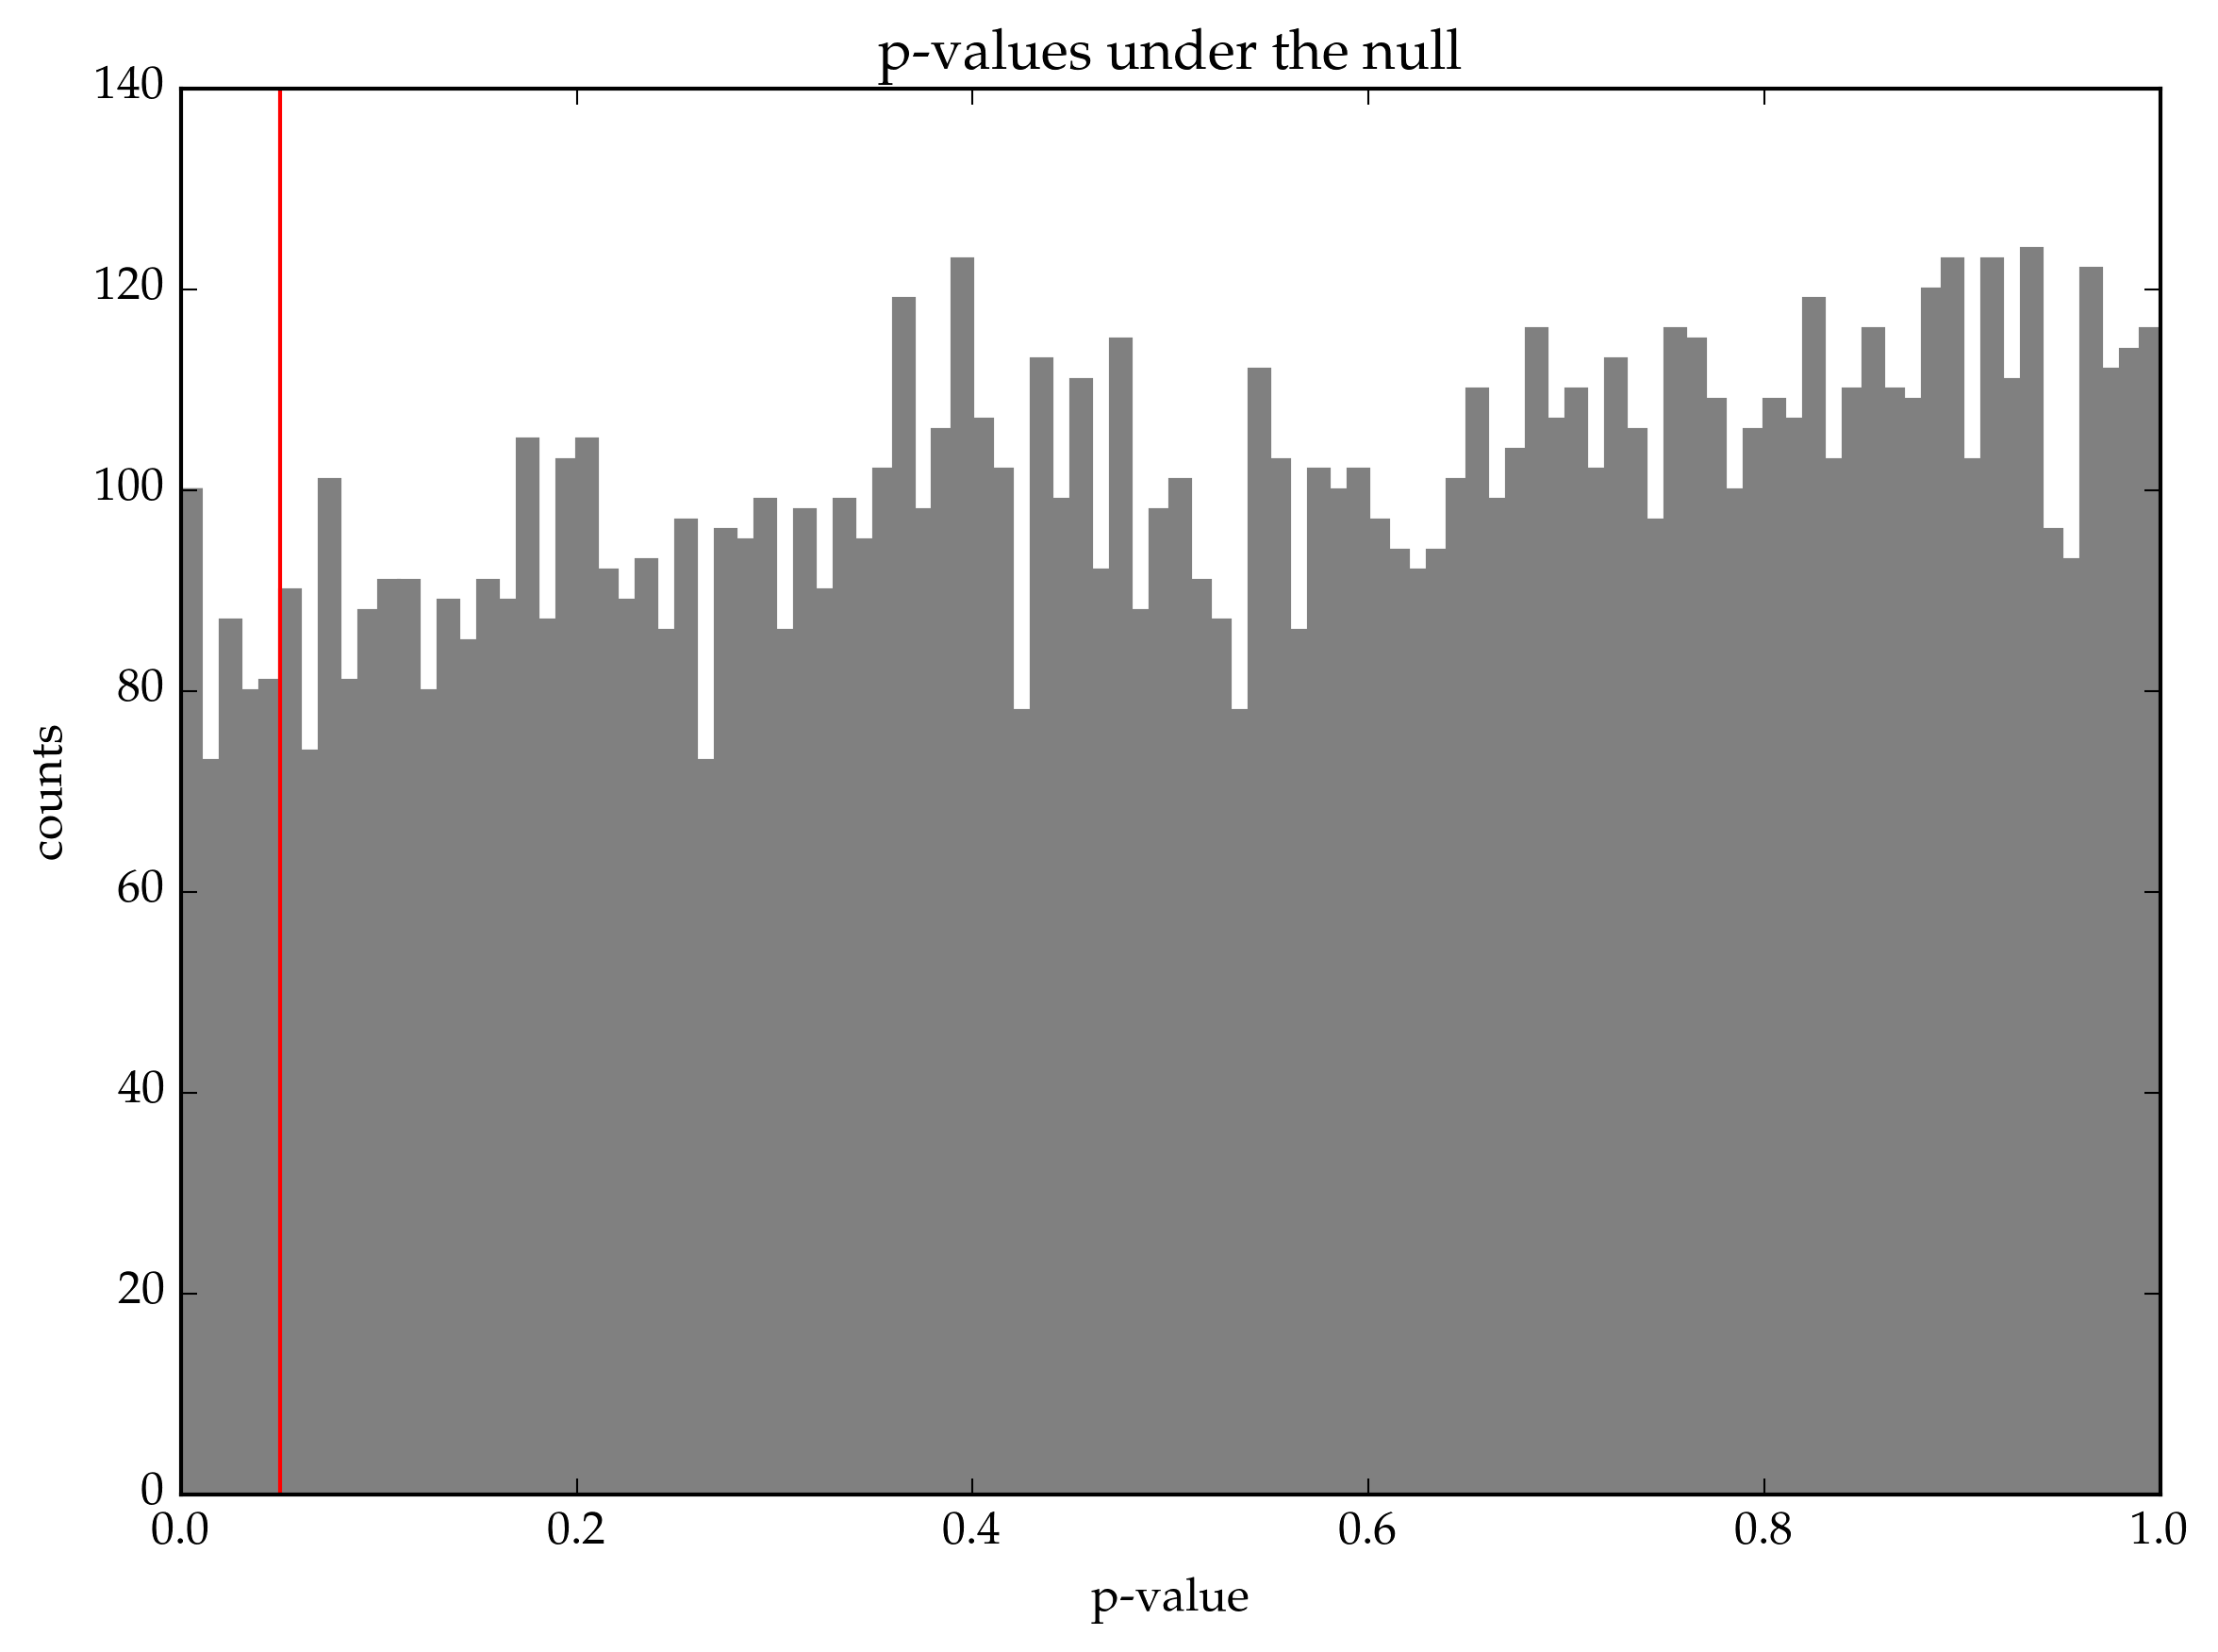

In [51]:
plt.plt[:interactive](true)
plt.axvline(0.05, color="red")
plt.plt[:interactive](false)
plt.plt[:hist](pvalues_null, bins=100, color="grey", edgecolor="grey")
plt.xlabel("p-value")
plt.ylabel("counts")
plt.title("p-values under the null")
;

The p-values aren't quite uniform. It looks like this test might be slightly conservative. Interesting...

## p-values under alternative

In [53]:
function sim_pval_alt(τ::Float64, ϵ::Float64)
    Ystar = rand(prior)
    Ystar[inside] .+= τ
    gp_fit_inside.y = Ystar[inside]
    gp_fit_outside.y = Ystar[!inside]
    update_alpha!(gp_fit_inside)
    update_alpha!(gp_fit_outside)
    extrap◫_inside = predict(gp_fit_inside, X◫; full_cov=true)
    extrap◫_outside = predict(gp_fit_outside, X◫; full_cov=true)
    μpost = extrap◫_inside[1].-extrap◫_outside[1]
    Σpost = extrap◫_inside[2]+extrap◫_outside[2]
    return get_pval(μpost, Σpost.mat, ϵ)
end

sim_pval_alt (generic function with 1 method)

In [54]:
pvalues_alt = Float64[sim_pval_alt(1.0, 0.01) for _ in 1:1000];

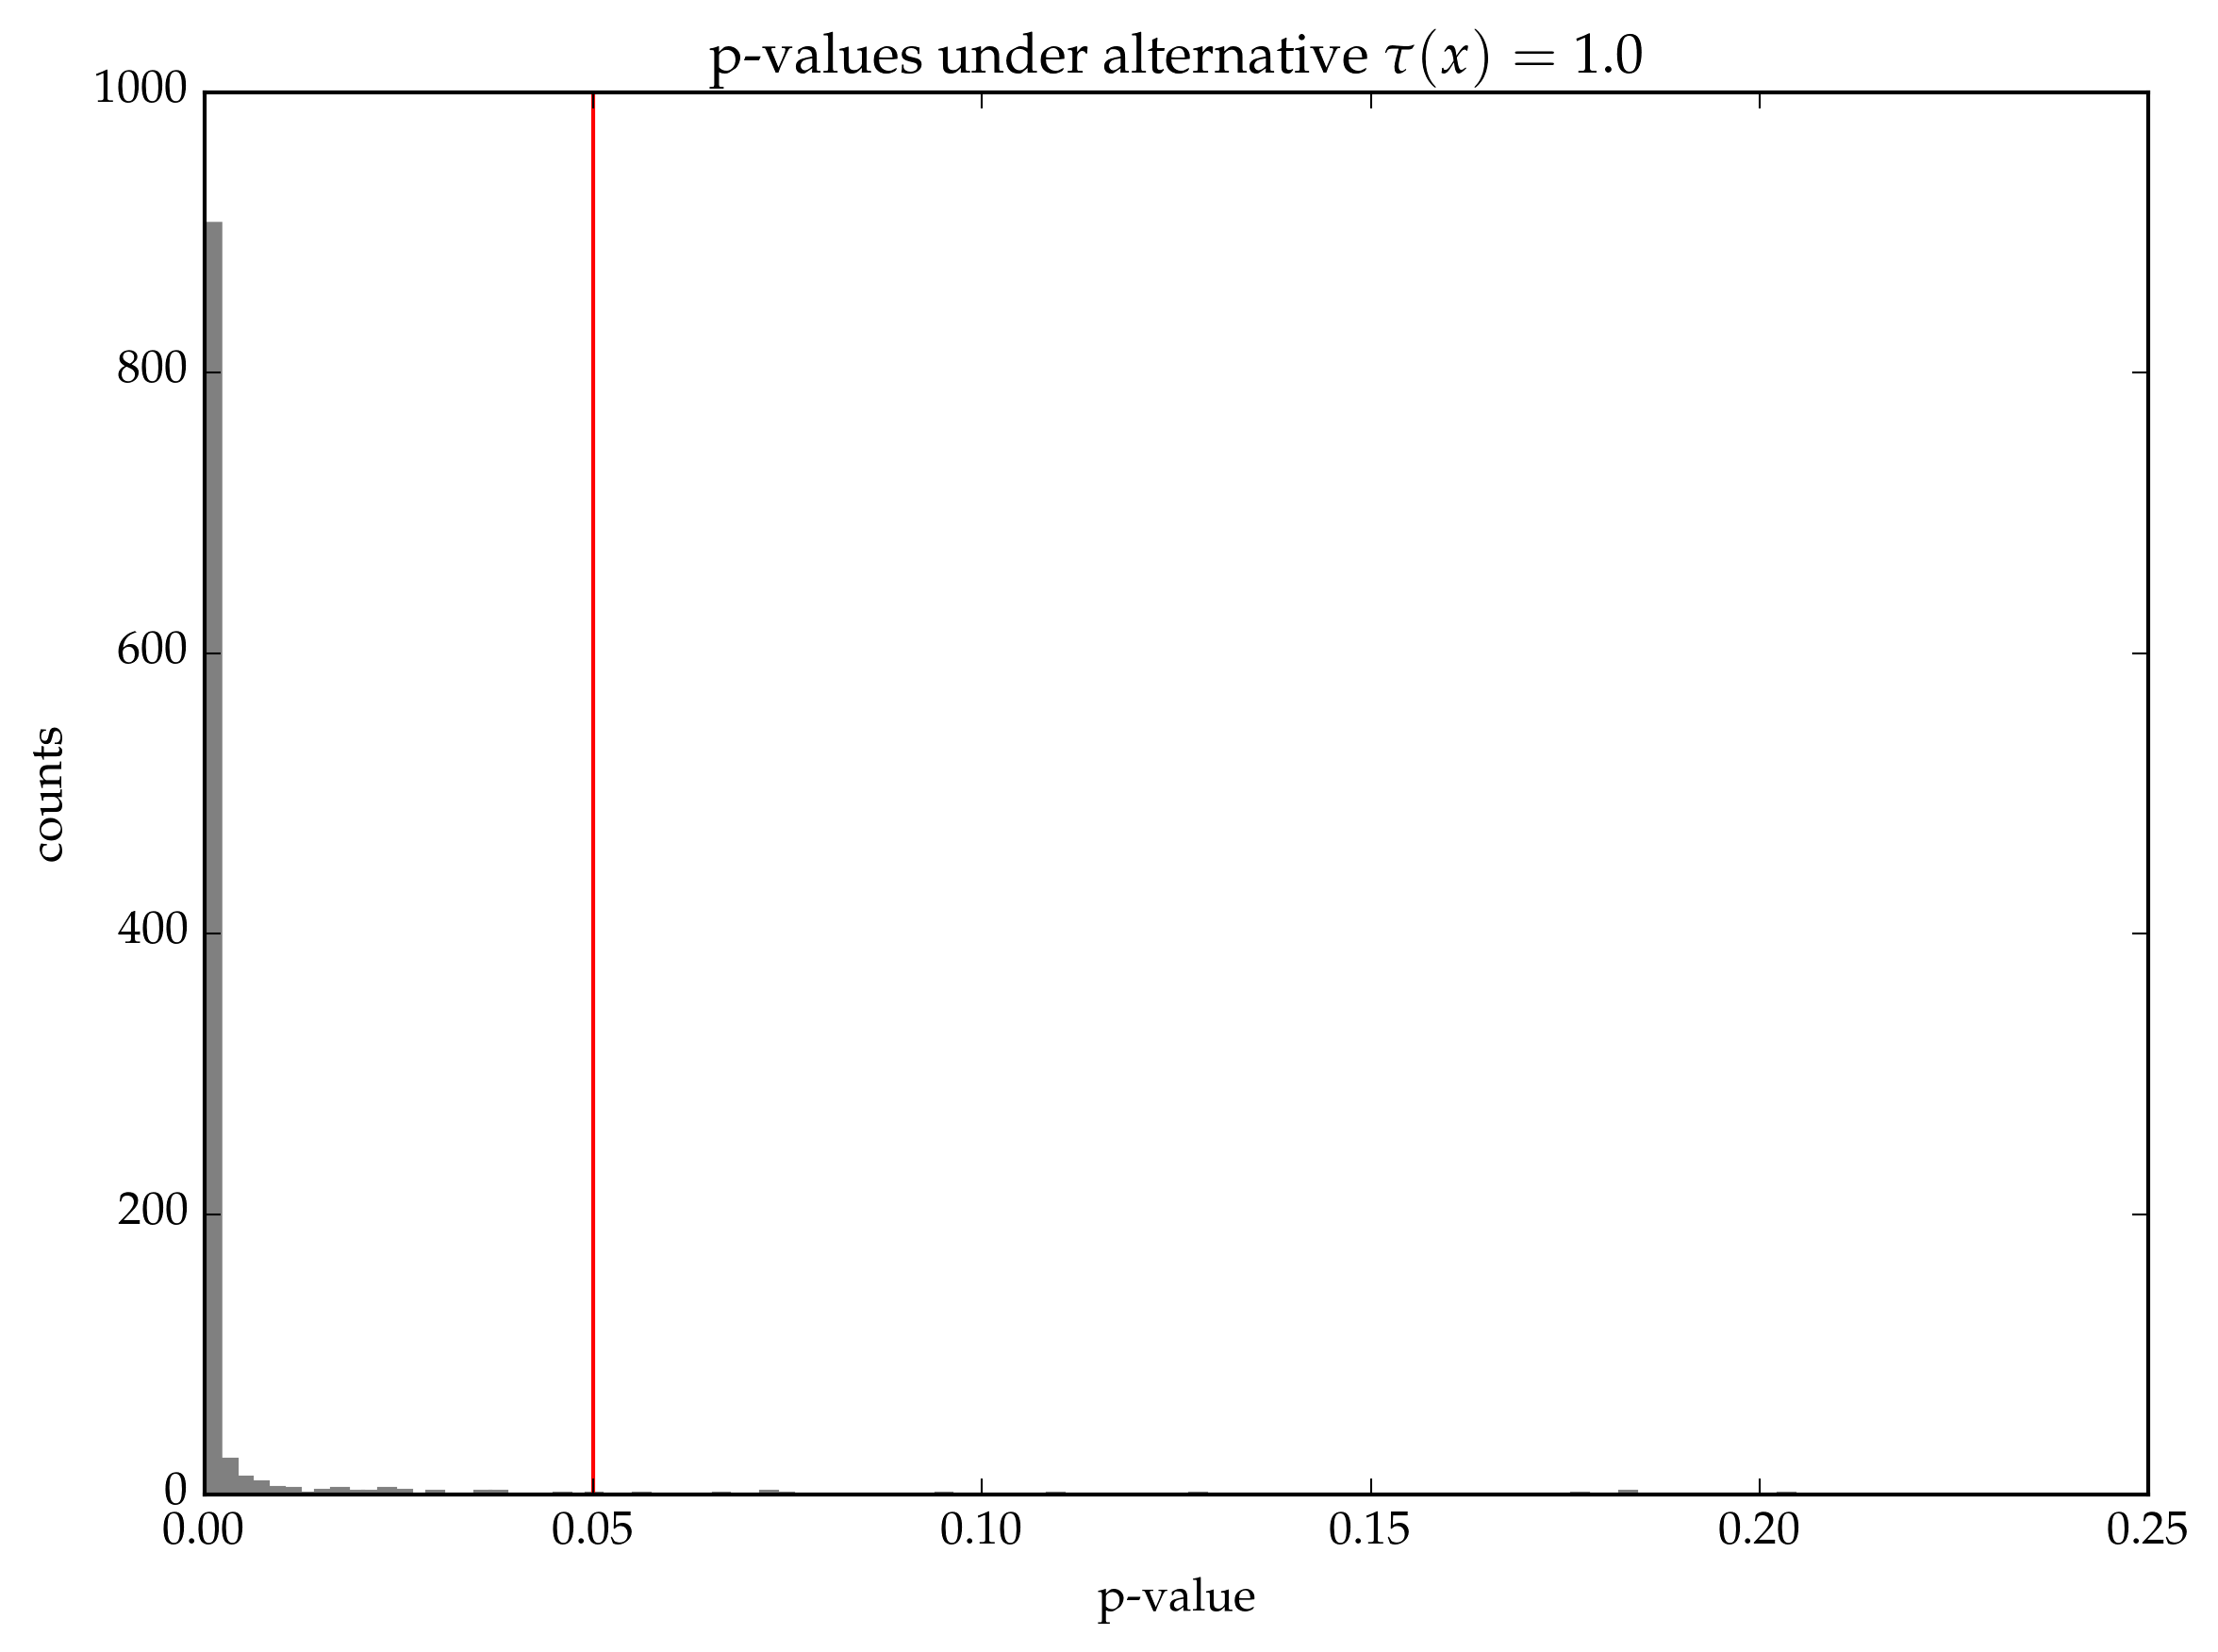

In [55]:
plt.plt[:interactive](true)
plt.axvline(0.05, color="red")
plt.plt[:interactive](false)
plt.plt[:hist](pvalues_alt, bins=100, color="grey", edgecolor="grey")
plt.xlabel("p-value")
plt.ylabel("counts")
plt.title(L"p-values under alternative $\tau(x)=1.0$")
plt.plt[:interactive](true)
;

In [56]:
mean(pvalues_alt.<0.05) # power

0.987

That high power is encouraging!

* test RDD assumptions
    * check the density of units is continuous across cut-point
    * i.e. check the sorting assumption
    * McClarey
    * http://www.maths.tcd.ie/~mnl/store/Diggle1985a.pdf